In [1]:
import pandas as pd
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", None)


In [2]:
import matplotlib as mpl
mpl.rcParams.update({
    "font.size": 12,          # default text
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})
DEFAULT_FONT_SIZE = 16

In [3]:

import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import bootstrap

output_folder = "analysis/figures"
full_df = pd.read_csv("results/all_runs_latest.csv")


## Formatting and plotting functions

In [4]:
def format_data(in_df):
    df = in_df.copy()
    df = df[(df['Run ID'].str.startswith('2026012'))]

    config_map = {
        "ctx1_fog00_p4pfalse_contract_contract_for_finishing_selfish11": "Finishing Contract",
        "ctx1_fog00_p4pfalse_contract_none_selfish11": "No Contract",
        "ctx1_fog00_p4pfalse_contract_strict_selfish11": "Strict Contract",
        "ctx1_fog00_p4pfalse_contract_tile_with_judge_implementation_selfish11": "Judge Contract",
        "ctx1_fog00_p4ptrue_contract_contract_for_finishing_selfish11": "P4P Finishing Contract",
        "ctx1_fog00_p4ptrue_contract_none_selfish11": "P4P No Contract",
        "ctx1_fog00_p4ptrue_contract_strict_selfish11": "P4P Strict Contract",
        "ctx1_fog00_p4ptrue_contract_tile_with_judge_implementation_selfish11": "P4P Judge Contract"
    }
    df['Config Label'] = df['Config ID'].map(config_map)
    df['Contract Type'] = df['Contract Type'].fillna('No Contract')
    df["Contract Type"] = df["Contract Type"].replace({
        "tile_with_judge_implementation": "NL-Trading",
        "strict": "Prog-Trading",
        "contract_for_finishing": "Prog-Points"
        })
    models = df["Model Pair"].str.partition("-")
    same_model = models[0] == models[2]
    df["Model"] = np.where(same_model, models[0], df["Model Pair"])
    df["Bucket"] = df["Bucket"].replace({
        "Independent (Both have optimal paths)": "Independent",
        "Needy Player (Blue)": "Asymmetric"
    })
    
    # check if 0 or 1 have final leverage tile in the gir
    def _has_final_leverage_tile(grid_str: str, target: str) -> bool:
        g = ast.literal_eval(grid_str)  # safer than eval
        return (g[2][3] == target) and (g[3][2] == target)
    df["Player 0 Has Final Leverage Tile"] = df["Grid"].apply(lambda s: _has_final_leverage_tile(s, "R"))
    df["Player 1 Has Final Leverage Tile"] = df["Grid"].apply(lambda s: _has_final_leverage_tile(s, "B"))
    df["Either Player Has Final Leverage Tile"] = df["Player 0 Has Final Leverage Tile"] | df["Player 1 Has Final Leverage Tile"]

    # core metrics: both finished and accuracy
    df['both_finished'] = (df['Reached Goal Player 0'] > 0) & (df['Reached Goal Player 1'] > 0)
    df['Normalized Total Score'] = df['Total Score'] / df['Max Possible Score']
    # df['Score P-Red'] = df['Score Player 0']
    # df['Score P-Blue'] = df['Score Player 1']

    
    # beating baselines is core metric for NPB analysis
    # For independent it is not possbile for both to beat baseline
    # For mutual dependency , it is equivalent to both finishing
    df['R_beats_baseline'] = df['Score Player 0'] > df['Non-Cooperative Baseline Player 0']
    df['B_beats_baseline'] = df['Score Player 1'] > df['Non-Cooperative Baseline Player 1']
    df['Both Players Beat Baseline'] = df['R_beats_baseline'] & df['B_beats_baseline']
    df['All Beat Baseline'] = df['Both Players Beat Baseline']
    
    ## equality measures
    ## use this to look at first mover advantage for contracts, as well as if P0 can leverage its better situation in NPB
    # points_proportion_0 another core metric (i prefer it to gini b/c easier to interpret)
    df["Proportion of Total Points for P-Red"] = df['Score Player 0'] / (df['Score Player 0'] + df['Score Player 1'])
    df['trade_volume_proportion_0'] = df['amount_received_by_0_from_trades'] / (df['amount_received_by_0_from_trades'] + df['amount_received_by_1_from_trades'])
    # note that player 1 keeping a p4p promise is equivalent to player 0 receiving a p4p payment
    df['p4p_volume_proportion_0'] = df['Total P4P Promises Kept Player 1'] / (df['Total P4P Promises Kept Player 1'] + df['Total P4P Promises Kept Player 0'])
    df['strict_contract_tile_proportion_0'] = df['num_tiles_promised_to_receive_from_contract_0'] / (df['num_tiles_promised_to_receive_from_contract_0'] + df['num_tiles_promised_to_receive_from_contract_1'])
    df['contract_for_finishing_points_proportion_0'] = df['points_for_completion_promised_to_0'] / (df['points_for_completion_promised_to_0'] + df['points_for_completion_promised_to_1'])
    
    df[[
        'points_for_completion_promised_to_0',
        'trade_volume_proportion_0',
        'p4p_volume_proportion_0',
        'strict_contract_tile_proportion_0',
        'contract_for_finishing_points_proportion_0']] = df[['points_for_completion_promised_to_0',
                                                             'trade_volume_proportion_0',
                                                             'p4p_volume_proportion_0',
                                                             'strict_contract_tile_proportion_0',
                                                             'contract_for_finishing_points_proportion_0']].fillna(0.5)  # if no contract, assume equal split
 
    ## cooperation metrics
    df['total_trade_volume'] = df['amount_received_by_0_from_trades'] + df['amount_received_by_1_from_trades']
    df['trade_acceptance_rate_0'] = df['Total Trades Accepted Player 0'] / df['Total Trades Proposed Player 1']
    df['trade_acceptance_rate_1'] = df['Total Trades Accepted Player 1'] / df['Total Trades Proposed Player 0']
    df['total_trade_acceptance_rate'] = (df['Total Trades Accepted Player 0'] + df['Total Trades Accepted Player 1']) / (df['Total Trades Proposed Player 0'] + df['Total Trades Proposed Player 1'])
    df['moves_made_under_strict_contract_total'] = df['moves_made_under_strict_contract_0'] + df['moves_made_under_strict_contract_1']
    df['Total Trades Proposed'] = df['Total Trades Proposed Player 0'] + df['Total Trades Proposed Player 1']

    df['parity_trade_acceptance_rate'] = (df['parity_trades_accepted_0'] + df['parity_trades_accepted_1']) / (df['parity_trades_offered_0'] + df['parity_trades_offered_1'])
    
    # if 0 accepts a concessionary trade, that means 1 proposed a extractive trade etc
    df['extractive_trades_acceptance_rate'] = (df['concessionary_trades_accepted_0'] + df['concessionary_trades_accepted_1']) / (df['extractive_trades_offered_0'] + df['extractive_trades_offered_1'])
    df['concessionary_trades_acceptance_rate'] = (df['extractive_trades_accepted_0'] + df['extractive_trades_accepted_1']) / (df['concessionary_trades_offered_0'] + df['concessionary_trades_offered_1'])

    # make bad trade flag
    any_parity = (df["parity_trades_offered_0"] > 0) | (df["parity_trades_offered_1"] > 0)
    any_conc = (df["concessionary_trades_offered_0"] > 0) | (df["concessionary_trades_offered_1"] > 0)


    # parity / concessionary trade by *red* (player 0)
    red_parity = df["parity_trades_offered_0"] > 0
    red_conc   = df["concessionary_trades_offered_0"] > 0
    red_parity_accepted = df["parity_trades_accepted_0"] > 0
    red_conc_accepted   = df["concessionary_trades_accepted_0"] > 0

    cond_independent = df["Bucket"] == "Independent"
    cond_asymmetric  = df["Bucket"] == "Asymmetric"

    df["Bad Trade"] = False
    df.loc[cond_independent & (any_parity | any_conc), "Bad Trade"] = True
    df.loc[cond_asymmetric  & (red_parity | red_conc | red_parity_accepted | red_conc_accepted), "Bad Trade"] = True


    # P4P promise honour rates
    df['P4P Promise Honour Rate 0'] = df['Total P4P Promises Kept Player 0'] / (df['Total P4P Promises Kept Player 0'] + df['Total P4P Promises Broken Player 0'])
    df['P4P Promise Honour Rate 1'] = df['Total P4P Promises Kept Player 1'] / (df['Total P4P Promises Kept Player 1'] + df['Total P4P Promises Broken Player 1'])
    df['Total P4P Promise Honour Rate'] = (df['Total P4P Promises Kept'] ) / (df['Total P4P Promises Kept'] + df['Total P4P Promises Broken'])

    for model_pair in df['Model Pair'].unique():
        print(f"Model Pair {model_pair} has {len(df[df['Model Pair'] == model_pair])} rows.")

    print(f"Formatted data with {len(df['Model Pair'].unique())} unique model pairs,  {len(df)} total rows")
    return df

In [7]:
def format_comparison_data(df):
    
    df_baseline = df[(df['Contract Type'] == 'No Contract') & (df['Pay4Partner'] == False)].copy()
    df_modifictations = df[(df['Contract Type'] != 'No Contract') | (df['Pay4Partner'] == True)].copy()
    df_compared_to_baseline = df_modifictations.merge(df_baseline, 
        on=['Model Pair', 'Grid ID'],
        suffixes=('', ' Baseline')
    )

    # df_compared_to_baseline['Normalized Total Score Change'] = df_compared_to_baseline['Normalized Total Score']-df_compared_to_baseline['Normalized Total Score Baseline']
    
    # df_compared_to_baseline['Proportion of Total Points for Red Player Change'] = df_compared_to_baseline['Proportion of Total Points for Red Player'] - df_compared_to_baseline['Proportion of Total Points for Red Player Baseline']

    # df_compared_to_baseline['Both Players Beat Baseline Change'] = df_compared_to_baseline['Both Players Beat Baseline'] - df_compared_to_baseline['all Players Beat Baseline Baseline'].astype(int)

    return df_compared_to_baseline

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mean_metric_bar(
    df: pd.DataFrame,
    metric: str,
    x: str,
    hue: str | None = None,
    filters: list[tuple[str, list]] | None = None,
    display_filter: bool = True,
    order: list | None = None,
    hue_order: list | None = None,
    figsize=(12, 6),
    title: str | None = None,
    rotate_xticks=10,
    ylim=(0, 1),
    palette="Set2",
):
    data = df.copy()

    filter_text = ""
    if filters:
        filter_text = ';\n '.join([f"{col} in {allowed}" for col, allowed in filters])
        for col, allowed in filters:
            if col not in data.columns:
                raise ValueError(f"Filter column '{col}' not in df.columns")
            data = data[data[col].isin(allowed)]

    required = [x, metric] + ([hue] if hue else [])
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        raise ValueError("No data left after filtering/dropna.")

    group_cols = [x] + ([hue] if hue else [])
    grouped = (
        data.groupby(group_cols, observed=True)[metric]
            .agg(mean="mean", std="std", n="count")
            .reset_index()
    )
    grouped["sem"] = np.where(grouped["n"] > 1, grouped["std"] / np.sqrt(grouped["n"]), 0.0)

    x_levels = order if order is not None else list(pd.unique(grouped[x]))
    if hue:
        h_levels = hue_order if hue_order is not None else list(pd.unique(grouped[hue]))
    else:
        h_levels = [None]

    if hue:
        mean_mat = grouped.pivot(index=x, columns=hue, values="mean").reindex(index=x_levels, columns=h_levels)
        sem_mat = grouped.pivot(index=x, columns=hue, values="sem").reindex(index=x_levels, columns=h_levels)
        colors = sns.color_palette(palette, n_colors=len(h_levels))
    else:
        mean_mat = grouped.set_index(x)["mean"].reindex(x_levels).to_frame("mean")
        sem_mat = grouped.set_index(x)["sem"].reindex(x_levels).to_frame("sem")
        colors = sns.color_palette(palette, n_colors=1)

    fig, ax = plt.subplots(figsize=figsize)

    x_pos = np.arange(len(x_levels))
    if hue:
        width = 0.8 / max(len(h_levels), 1)
        offsets = (np.arange(len(h_levels)) - (len(h_levels) - 1) / 2) * width

        for j, h_val in enumerate(h_levels):
            y = mean_mat[h_val].to_numpy(dtype=float)
            yerr = sem_mat[h_val].to_numpy(dtype=float)

            ax.bar(
                x_pos + offsets[j],
                y,
                width=width,
                yerr=yerr,
                capsize=4,
                label=str(h_val),
                color=colors[j],
                alpha=0.9,
                edgecolor="black",
                linewidth=0.3,
            )
        ax.legend(title=hue, loc="best")
    else:
        y = mean_mat["mean"].to_numpy(dtype=float)
        yerr = sem_mat["sem"].to_numpy(dtype=float)

        # one color per x-level
        bar_colors = sns.color_palette(palette, n_colors=len(x_levels))

        ax.bar(
            x_pos,
            y,
            width=0.7,
            yerr=yerr,
            capsize=4,
            color=bar_colors,
            alpha=0.9,
            edgecolor="black",
            linewidth=0.3,
        )

    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(v) for v in x_levels], rotation=rotate_xticks, ha="right", fontsize=DEFAULT_FONT_SIZE)
    # ax.set_xlabel(x, fontsize=DEFAULT_FONT_SIZE)
    ax.set_ylabel(f"Mean {metric.replace('_',' ')}", fontsize=DEFAULT_FONT_SIZE)
    # ax.set_title(title if title else f"{metric}" + (f"\n {filter_text}" if filter_text and display_filter else ""))

    if ylim is not None:
        ax.set_ylim(*ylim)

    plt.savefig(f"{output_folder}/mean_{metric.replace(' ', '_').lower()}_by_{x.lower()}.pdf", format="pdf", bbox_inches="tight")
    fig.tight_layout()
    plt.show()

    return grouped

## Creating Data

In [9]:
df = format_data(full_df)
df_compared_to_baseline = format_comparison_data(df)


Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows


In [8]:
df['Contract Type'].unique()

array(['Prog-Points', 'No Contract', 'Prog-Trading', 'NL-Trading'],
      dtype=object)

In [9]:
model_order = ['FOUR_1', 'HAIKU_4_5', 'LLAMA_MAVERICK', 'LLAMA_SCOUT', 'QWEN_3_235B', 'QWEN_3_30B']
bucket_order = ["Independent", "Mutual Dependency", "Asymmetric"]
contract_order = ['No Contract', 'Prog-Points',   'NL-Trading', 'Prog-Trading']

## Core Baseline Metric Plots

In [ ]:
core_metrics = [{'df': df,
    'metric': 'Normalized Total Score',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['No Contract'])],
          
},
{'df': df,
    'metric': 'Proportion of Total Points for Red Player',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['No Contract']),
                ],
},
{'df': df,
    'metric': 'all Players Beat Baseline',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['No Contract']),
                ('Bucket', ['Asymmetric'])],
},


       ]

Plotting metric: Percent of Max Score


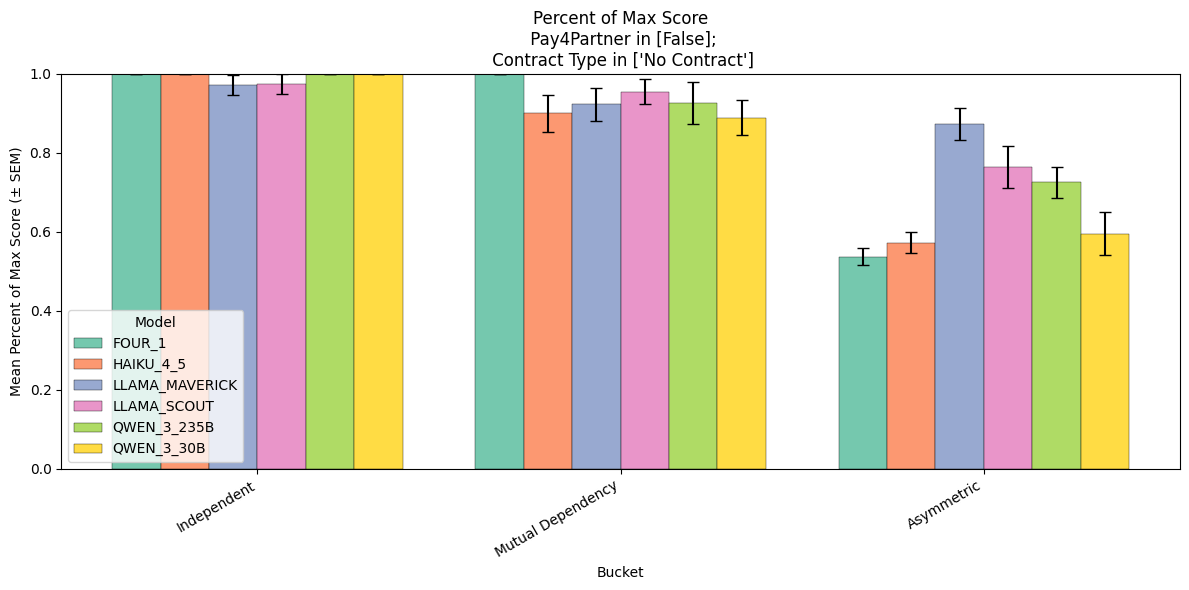

Plotting metric: Proportion of Total Points for Red Player


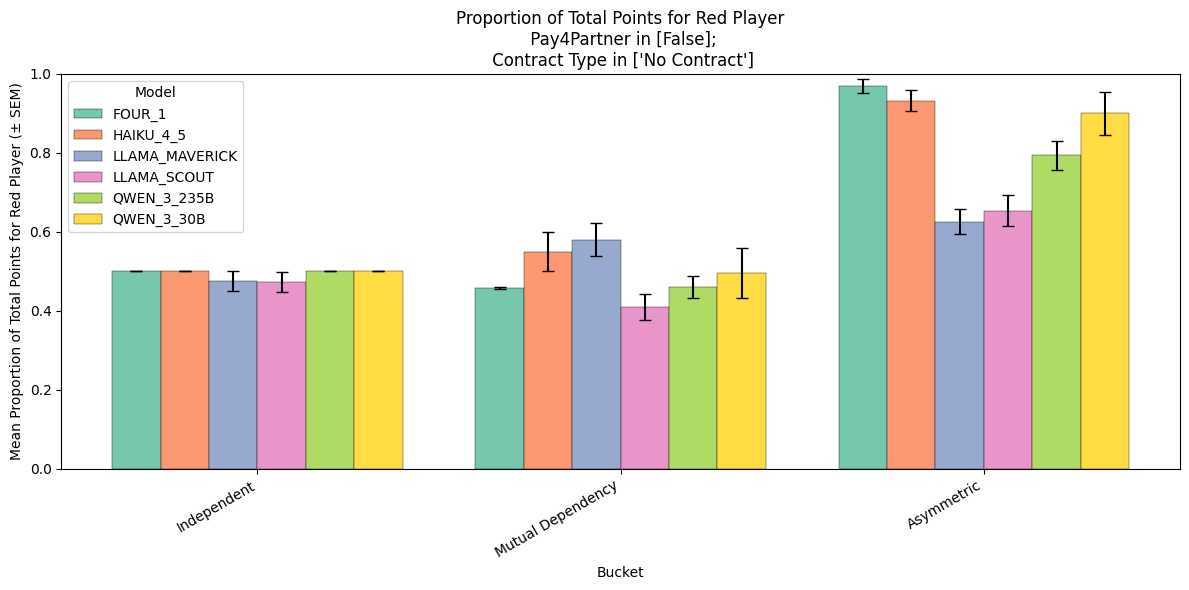

Plotting metric: Both Players Beat Baseline


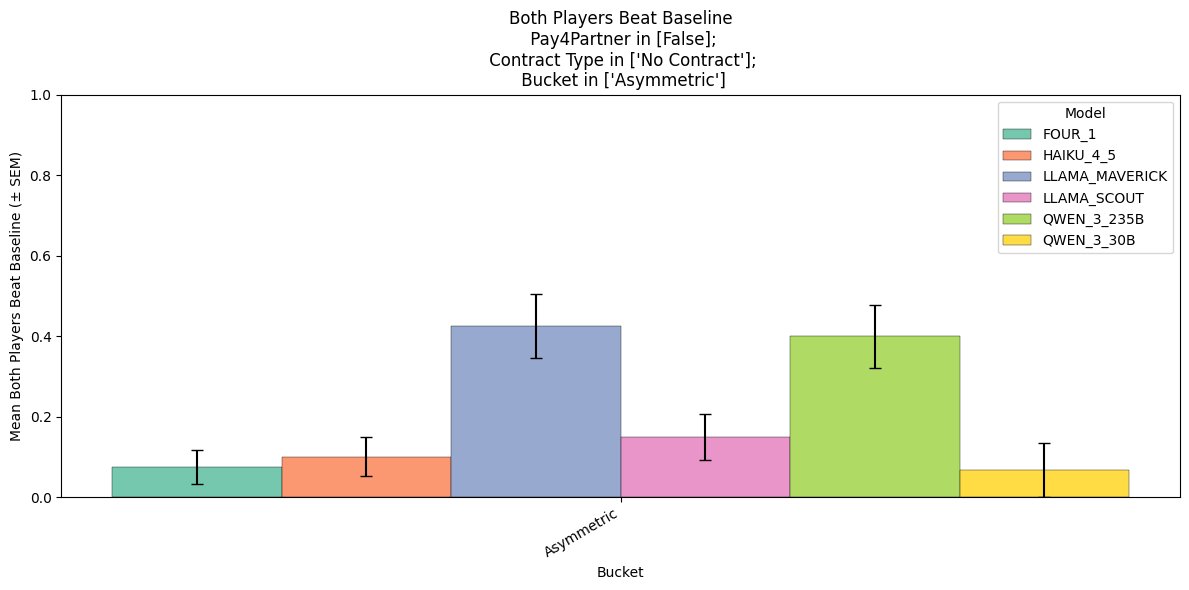

In [136]:
for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
    )

## Strict Contracts

In [ ]:
core_metrics = [{'df': df_compared_to_baseline,
    'metric': 'Normalized Total Score Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['strict'])],
          
},
{'df': df_compared_to_baseline,
    'metric': 'Proportion of Total Points for Red Player Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['strict']),
                ],
},
{'df': df_compared_to_baseline,
    'metric': 'all Players Beat Baseline Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['strict']),
                ('Bucket', ['Asymmetric'])],
},


       ]

Plotting metric: Percent of Max Score Change


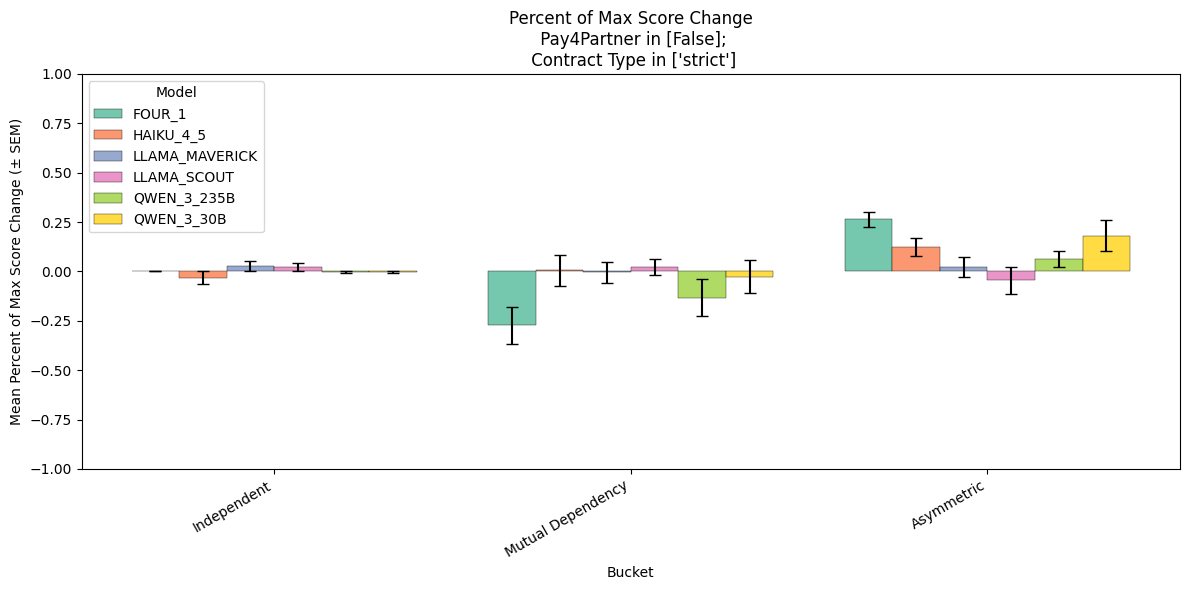

Plotting metric: Proportion of Total Points for Red Player Change


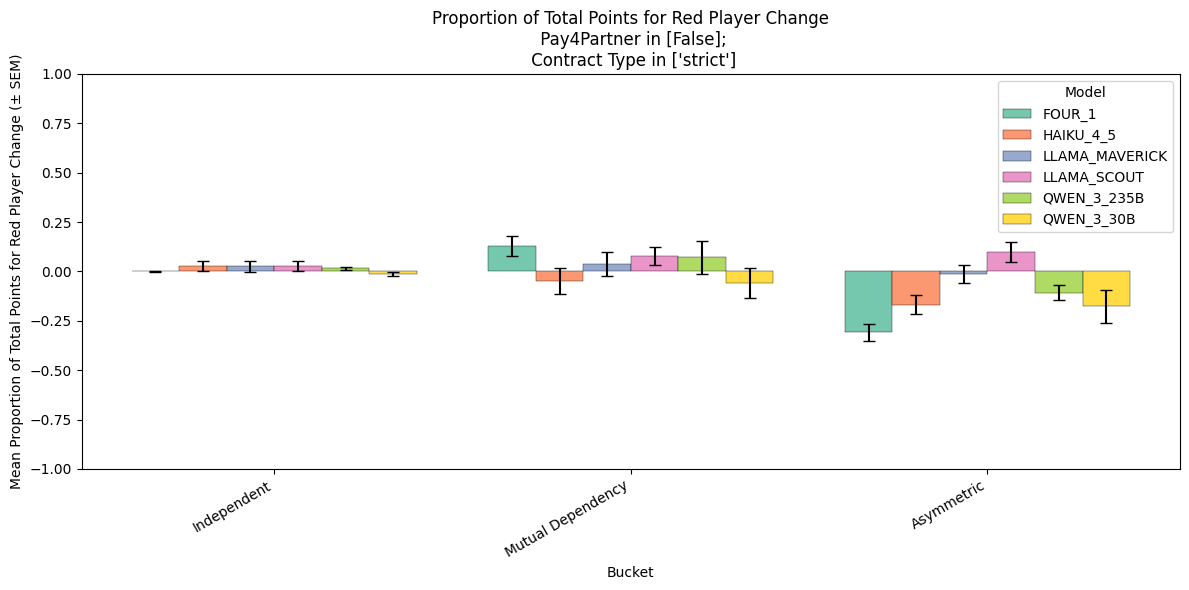

Plotting metric: Both Players Beat Baseline Change


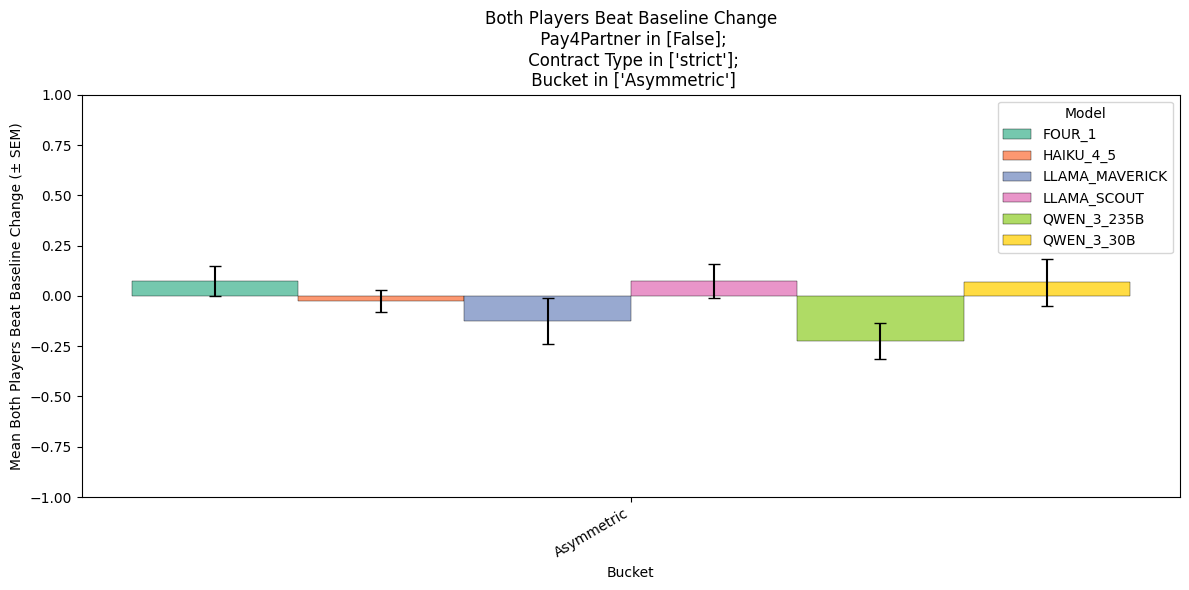

In [152]:
for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=(-1, 1),
    )

## Contract For Finishing 

Plotting metric: Percent of Max Score Change


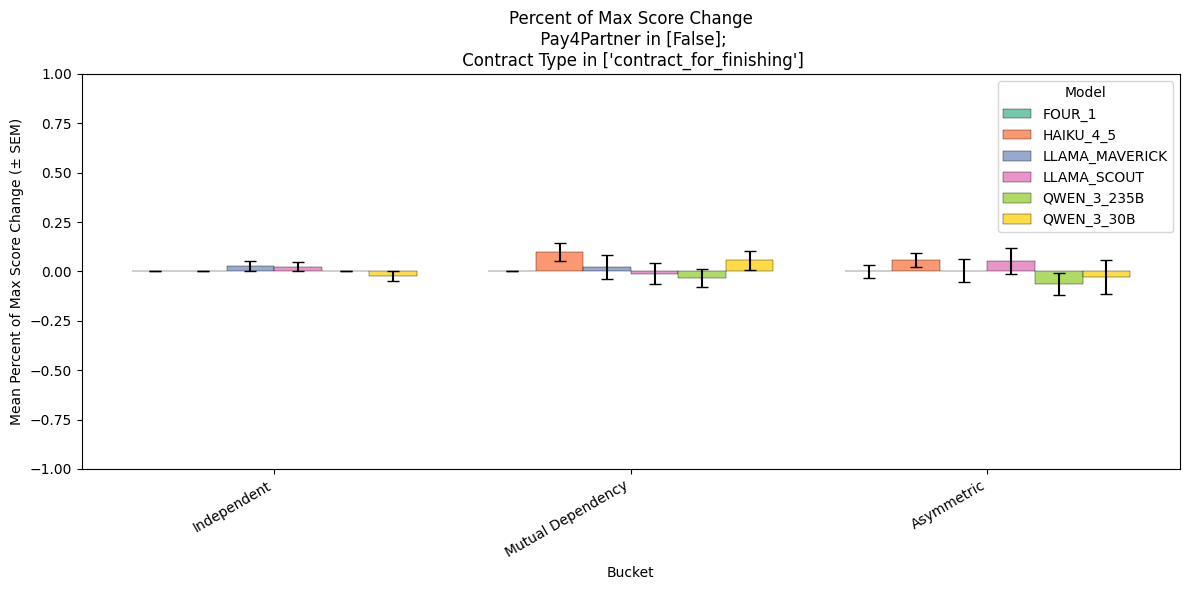

Plotting metric: Proportion of Total Points for Red Player Change


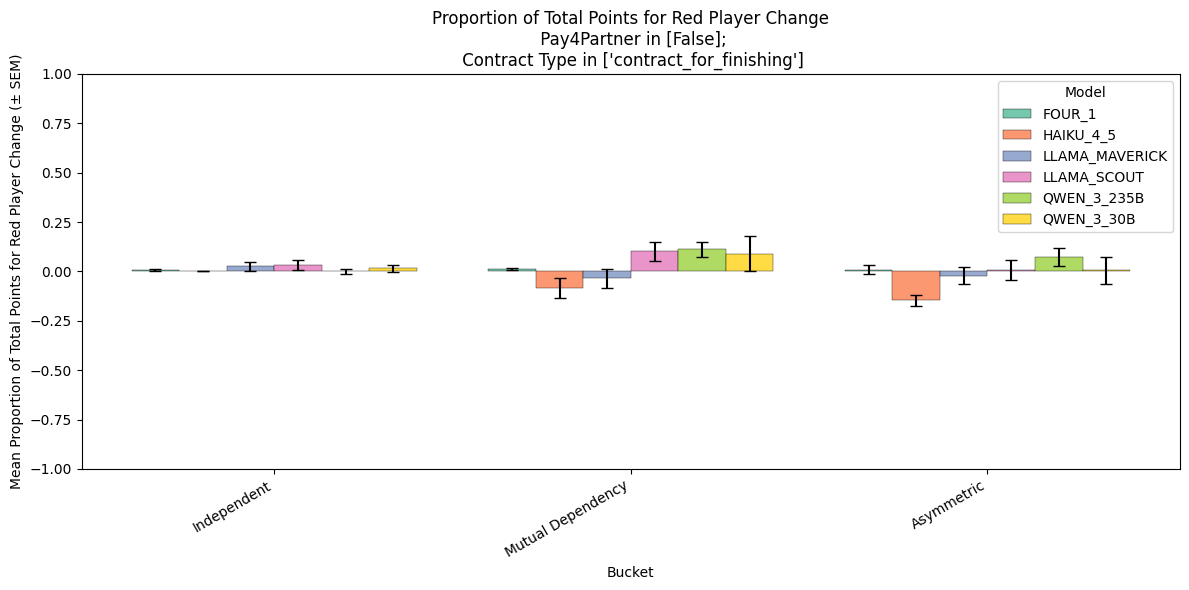

Plotting metric: Both Players Beat Baseline Change


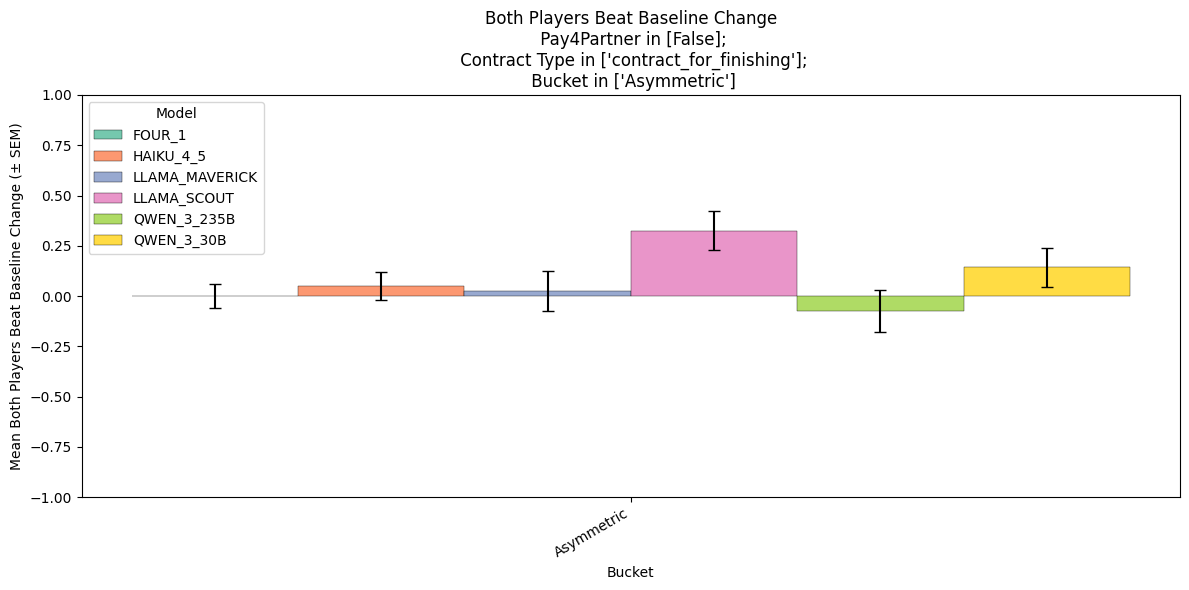

In [ ]:
core_metrics = [{'df': df_compared_to_baseline,
    'metric': 'Normalized Total Score Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['contract_for_finishing'])],
          
},
{'df': df_compared_to_baseline,
    'metric': 'Proportion of Total Points for Red Player Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['contract_for_finishing']),
                ],
},
{'df': df_compared_to_baseline,
    'metric': 'Both Players Beat Baseline Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['contract_for_finishing']),
                ('Bucket', ['Asymmetric'])],
},


       ]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=(-1, 1),
    )

## LLM Judge 

Plotting metric: Percent of Max Score


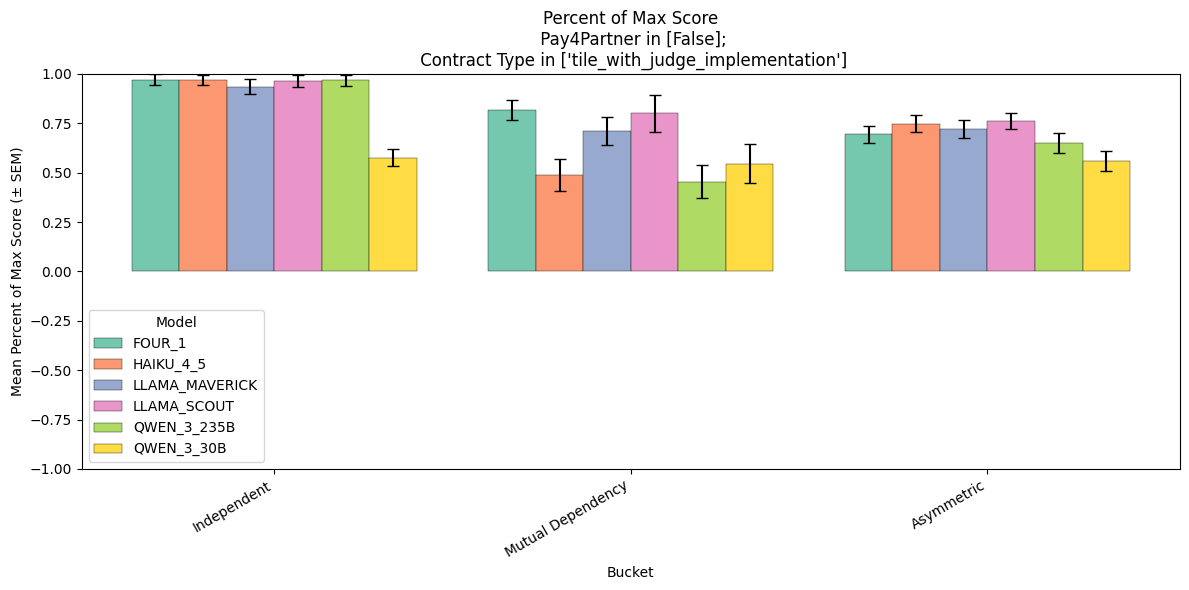

Plotting metric: Proportion of Total Points for Red Player


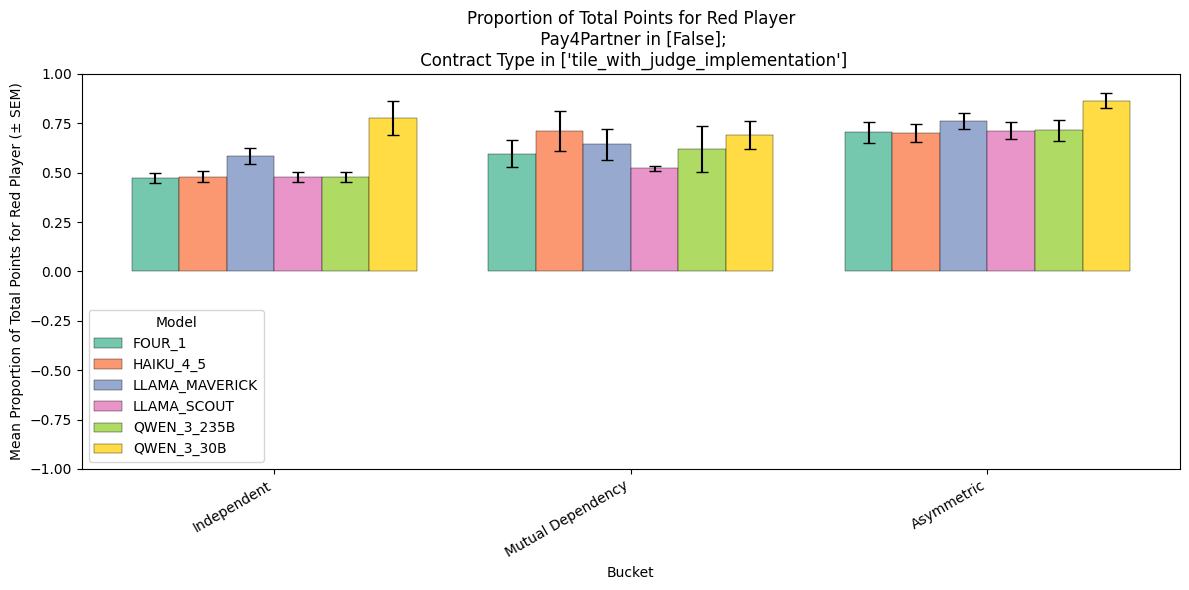

Plotting metric: Both Players Beat Baseline Change


ValueError: Missing required columns: ['Both Players Beat Baseline Change']

In [ ]:
core_metrics = [{'df': df_compared_to_baseline,
    'metric': 'Normalized Total Score',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['tile_with_judge_implementation'])],
          
},
{'df': df_compared_to_baseline,
    'metric': 'Proportion of Total Points for Red Player',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['tile_with_judge_implementation']),
                ],
},
{'df': df_compared_to_baseline,
    'metric': 'Both Players Beat Baseline Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['tile_with_judge_implementation']),
                ('Bucket', ['Asymmetric'])],
},


       ]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=(-1, 1),
    )

## Computing change with bootstrapped error bars using log of the lift 

## Bootstrap function and lift plotting function

In [27]:
def bootstrap_relative_lift(df_compared, column_name, iterations=10000):
    exp_col = column_name
    base_col = f"{column_name} Baseline"
    
    lifts = []
    n = len(df_compared)
    
    for _ in range(iterations):
        sample = df_compared.sample(n=n, replace=True)
        
        total_exp = sample[exp_col].sum() 
        total_base = sample[base_col].sum() 
        
        # Calculate log of the ratio
        lifts.append(total_exp / total_base)
    
    # Calculate results in log space, then exponentiate back to "x" factor
    mean_lift = np.mean(lifts)
    
    # Using 2.5 and 97.5 for a standard 95% Confidence Interval
    ci_lower = np.percentile(lifts, 2.5)
    ci_upper = np.percentile(lifts, 97.5)
    
    return mean_lift, (ci_lower, ci_upper)
# test = df_compared_to_baseline[
#     (df_compared_to_baseline['Pay4Partner'] == False) &
#    (df_compared_to_baseline['Model'] == 'FOUR_1') &
#    (df_compared_to_baseline['Bucket'] == 'Asymmetric') &
# (df_compared_to_baseline['Contract Type' ]== 'strict')
# ].copy()

# # Example Usage:
# ratio, ci = bootstrap_relative_lift_log(test, 'Both Players Beat Baseline')
# print(f"Relative Lift: {ratio:.2f}x (95% CI: {ci[0]:.2f} - {ci[1]:.2f})")

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bootstrap_relative_lift_bar(
    df: pd.DataFrame,
    metric: str,
    x: str,
    hue: str | None = None,
    filters: list[tuple[str, list]] | None = None,
    display_filter: bool = True,
    order: list | None = None,
    hue_order: list | None = None,
    figsize=(12, 6),
    title: str | None = None,
    rotate_xticks=30,
    ylim=None,                 # ratios often look better without forcing 0..1
    palette="Set2",
    iterations: int = 10000,   # forwarded to bootstrap_relative_lift_log
    show_hline_at_1: bool = True,
):
    """
    Same interface/behavior as plot_mean_metric_bar, except bar heights and error bars come from:
        bootstrap_relative_lift_log(group_df, metric, iterations=iterations)
    which returns: (value, (ci_lower, ci_upper))

    Error bars are plotted as asymmetric CI bars.
    """
    data = df.copy()

    filter_text = ""
    if filters:
        filter_text = ';\n '.join([f"{col} in {allowed}" for col, allowed in filters])
        for col, allowed in filters:
            if col not in data.columns:
                raise ValueError(f"Filter column '{col}' not in df.columns")
            data = data[data[col].isin(allowed)]

    required = [x, metric] + ([hue] if hue else [])
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        raise ValueError("No data left after filtering/dropna.")

    # Determine category orders
    x_levels = order if order is not None else list(pd.unique(data[x]))
    if hue:
        h_levels = hue_order if hue_order is not None else list(pd.unique(data[hue]))
    else:
        h_levels = [None]

    # Compute bootstrap estimates per (x, hue) group
    rows = []
    if hue:
        for xv in x_levels:
            for hv in h_levels:
                g = data[(data[x] == xv) & (data[hue] == hv)]
                if g.empty:
                    continue
                val, ci = bootstrap_relative_lift(g, metric, iterations=iterations)
                rows.append({
                    x: xv,
                    hue: hv,
                    "value": float(val),
                    "ci_lower": float(ci[0]),
                    "ci_upper": float(ci[1]),
                    "n": int(len(g)),
                })
    else:
        for xv in x_levels:
            g = data[data[x] == xv]
            if g.empty:
                continue
            val, ci = bootstrap_relative_lift(g, metric, iterations=iterations)
            rows.append({
                x: xv,
                "value": float(val),
                "ci_lower": float(ci[0]),
                "ci_upper": float(ci[1]),
                "n": int(len(g)),
            })

    grouped = pd.DataFrame(rows)
    if grouped.empty:
        raise ValueError("No groups to plot after filtering.")

    # Matrices for plotting (keep same layout logic as plot_mean_metric_bar)
    if hue:
        val_mat = grouped.pivot(index=x, columns=hue, values="value").reindex(index=x_levels, columns=h_levels)
        lo_mat = grouped.pivot(index=x, columns=hue, values="ci_lower").reindex(index=x_levels, columns=h_levels)
        hi_mat = grouped.pivot(index=x, columns=hue, values="ci_upper").reindex(index=x_levels, columns=h_levels)
        colors = sns.color_palette(palette, n_colors=len(h_levels))
    else:
        val_mat = grouped.set_index(x)["value"].reindex(x_levels).to_frame("value")
        lo_mat = grouped.set_index(x)["ci_lower"].reindex(x_levels).to_frame("ci_lower")
        hi_mat = grouped.set_index(x)["ci_upper"].reindex(x_levels).to_frame("ci_upper")
        colors = sns.color_palette(palette, n_colors=1)

    fig, ax = plt.subplots(figsize=figsize)

    x_pos = np.arange(len(x_levels))
    if hue:
        width = 0.8 / max(len(h_levels), 1)
        offsets = (np.arange(len(h_levels)) - (len(h_levels) - 1) / 2) * width

        for j, h_val in enumerate(h_levels):
            y = val_mat[h_val].to_numpy(dtype=float)
            lo = lo_mat[h_val].to_numpy(dtype=float)
            hi = hi_mat[h_val].to_numpy(dtype=float)

            # asymmetric error bars: [lower, upper]
            yerr = np.vstack([y - lo, hi - y])
            # handle NaNs gracefully
            yerr = np.nan_to_num(yerr, nan=0.0)

            ax.bar(
                x_pos + offsets[j],
                y,
                width=width,
                yerr=yerr,
                capsize=4,
                label=str(h_val),
                color=colors[j],
                alpha=0.9,
                edgecolor="black",
                linewidth=0.3,
            )
        ax.legend(title=hue, loc="best")
    else:
        y = val_mat["value"].to_numpy(dtype=float)
        lo = lo_mat["ci_lower"].to_numpy(dtype=float)
        hi = hi_mat["ci_upper"].to_numpy(dtype=float)
        yerr = np.vstack([y - lo, hi - y])
        yerr = np.nan_to_num(yerr, nan=0.0)

        # one color per x-level (like your updated mean plot)
        bar_colors = sns.color_palette(palette, n_colors=len(x_levels))

        ax.bar(
            x_pos,
            y,
            width=0.7,
            yerr=yerr,
            capsize=4,
            color=bar_colors,
            alpha=0.9,
            edgecolor="black",
            linewidth=0.3,
        )

    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(v) for v in x_levels], rotation=rotate_xticks, ha="right")
    ax.set_xlabel(x)
    ax.set_ylabel(f"{metric} (change relative to baseline)")
    ax.set_title(title if title else f"{metric} change relative to baseline" + (f"\n {filter_text}" if filter_text and display_filter else ""))

    if show_hline_at_1:
        ax.axhline(1.0, color="black", linewidth=1, alpha=0.6)

    if ylim is not None:
        ax.set_ylim(*ylim)

    fig.tight_layout()
    plt.show()

    return grouped

## PLot Lift

Plotting metric: Percent of Max Score | Contract: Strict Tile | Pay4Partner: False


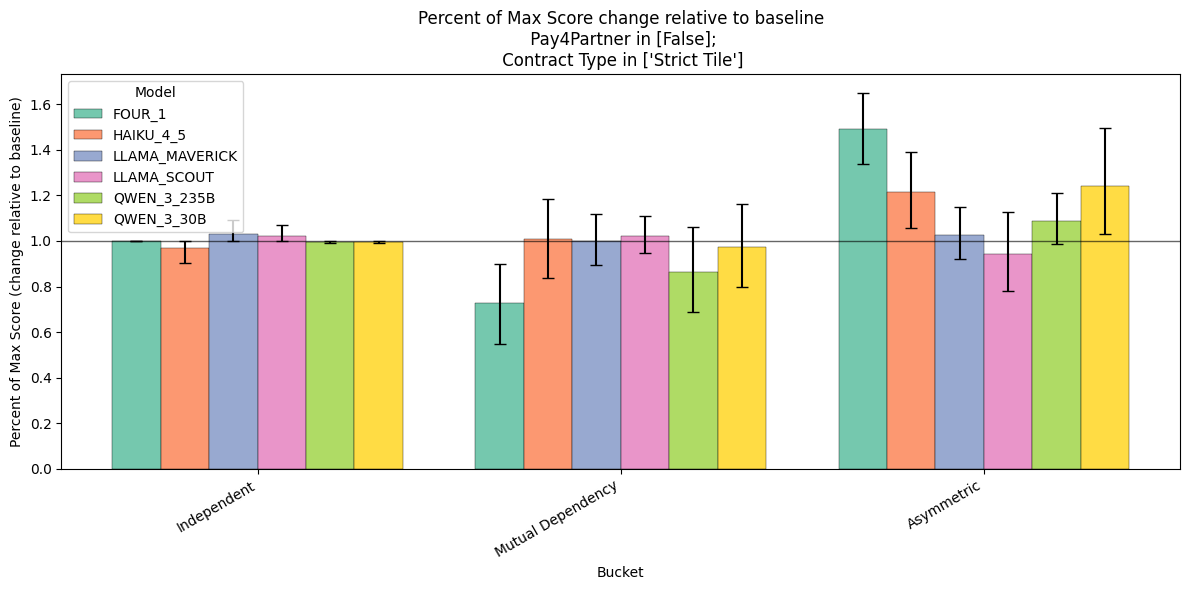

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Tile | Pay4Partner: False


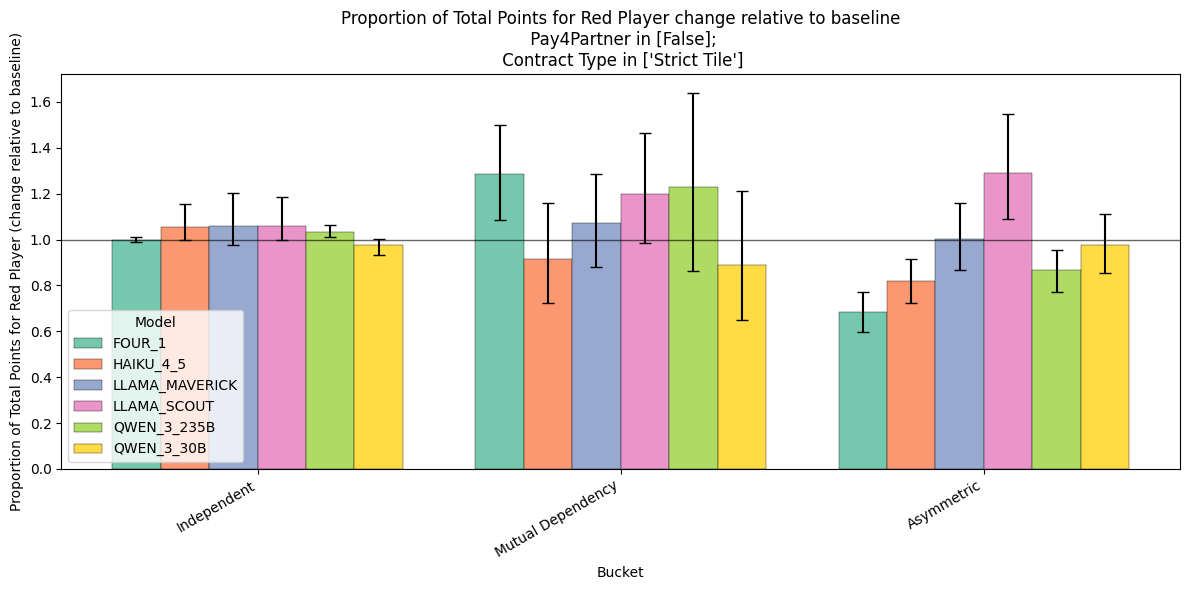

Plotting metric: Percent of Max Score | Contract: Natural Language Tile | Pay4Partner: False


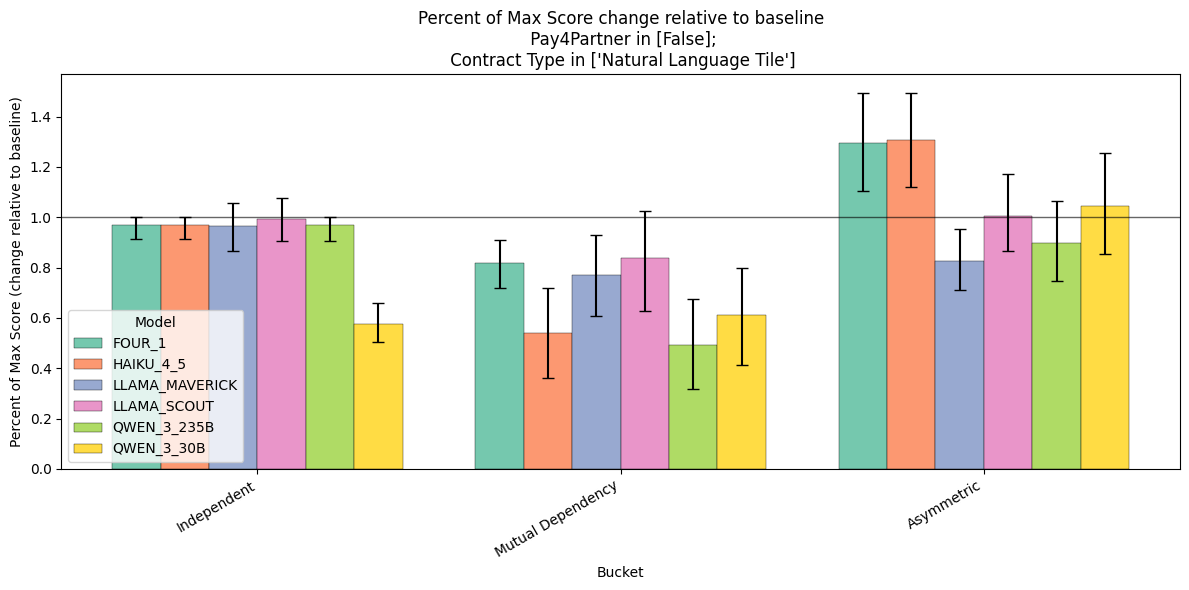

Plotting metric: Proportion of Total Points for Red Player | Contract: Natural Language Tile | Pay4Partner: False


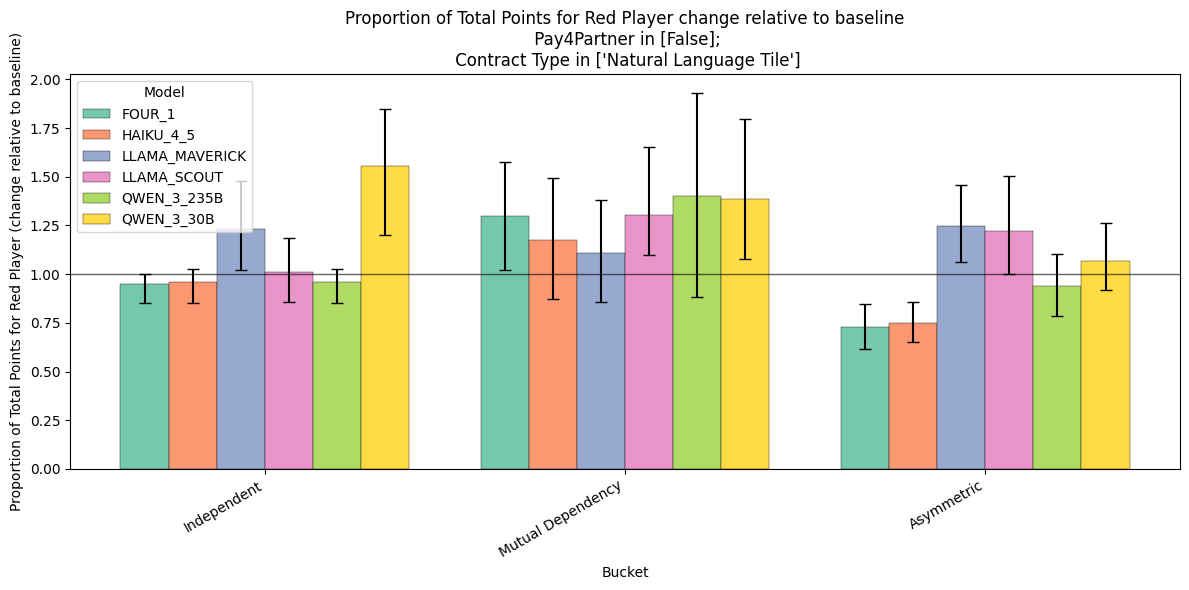

Plotting metric: Percent of Max Score | Contract: Strict Finishing | Pay4Partner: False


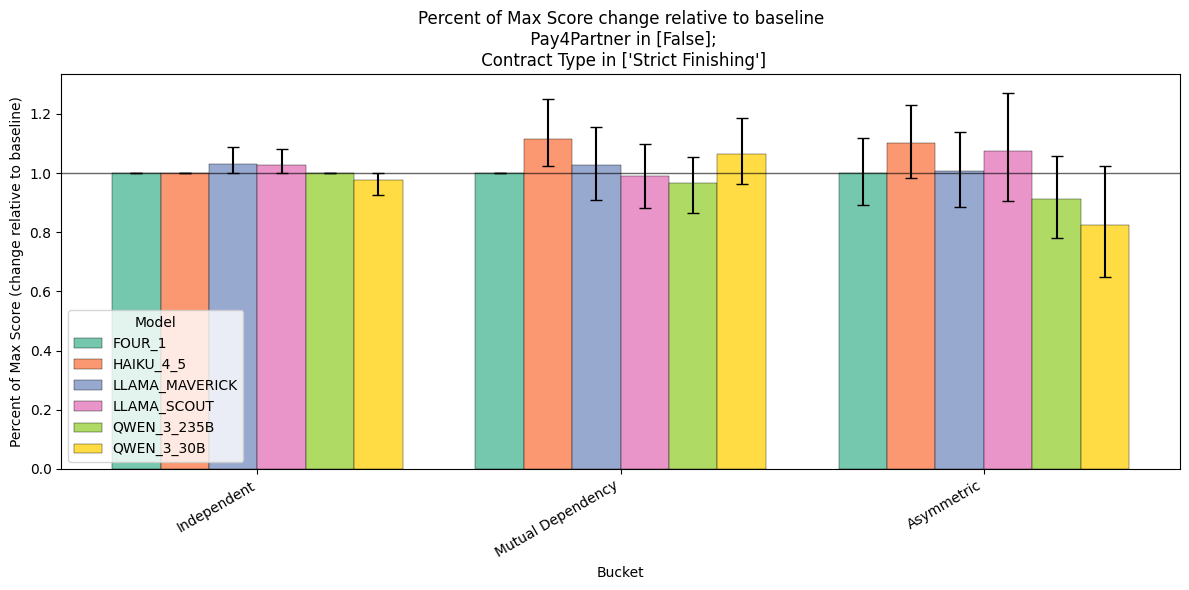

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Finishing | Pay4Partner: False


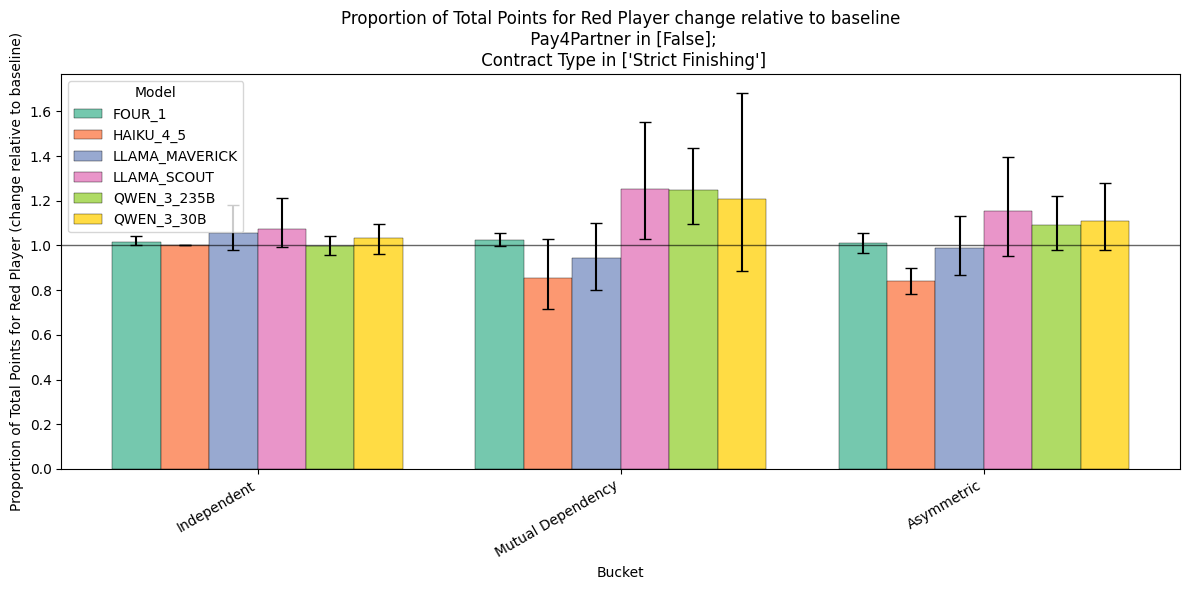

Plotting metric: Percent of Max Score | Contract: No Contract | Pay4Partner: True


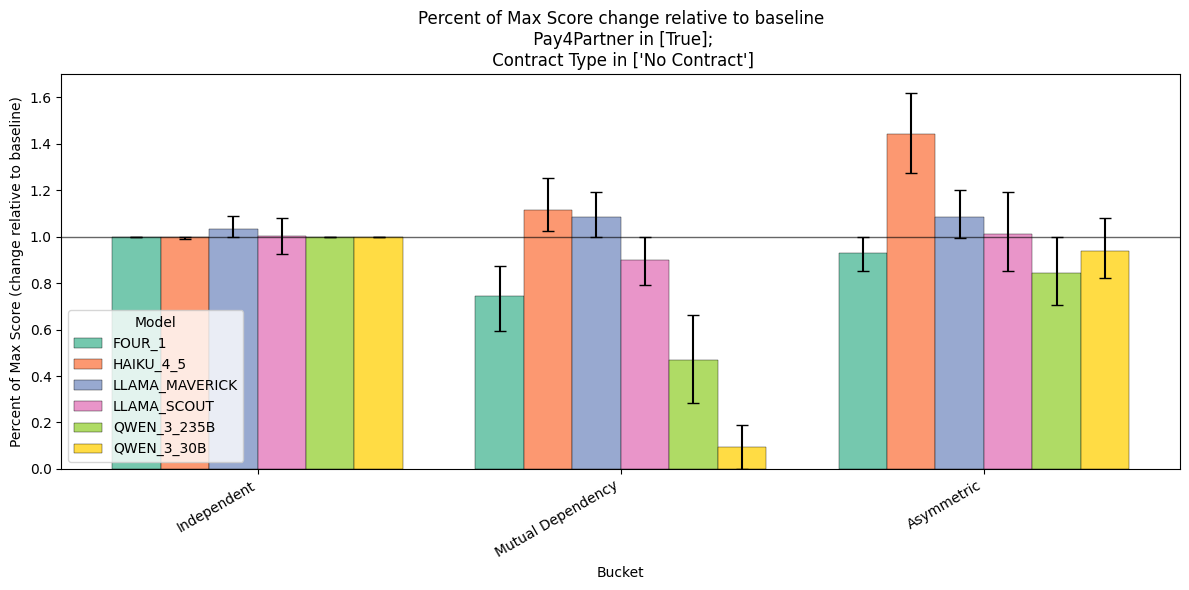

Plotting metric: Proportion of Total Points for Red Player | Contract: No Contract | Pay4Partner: True


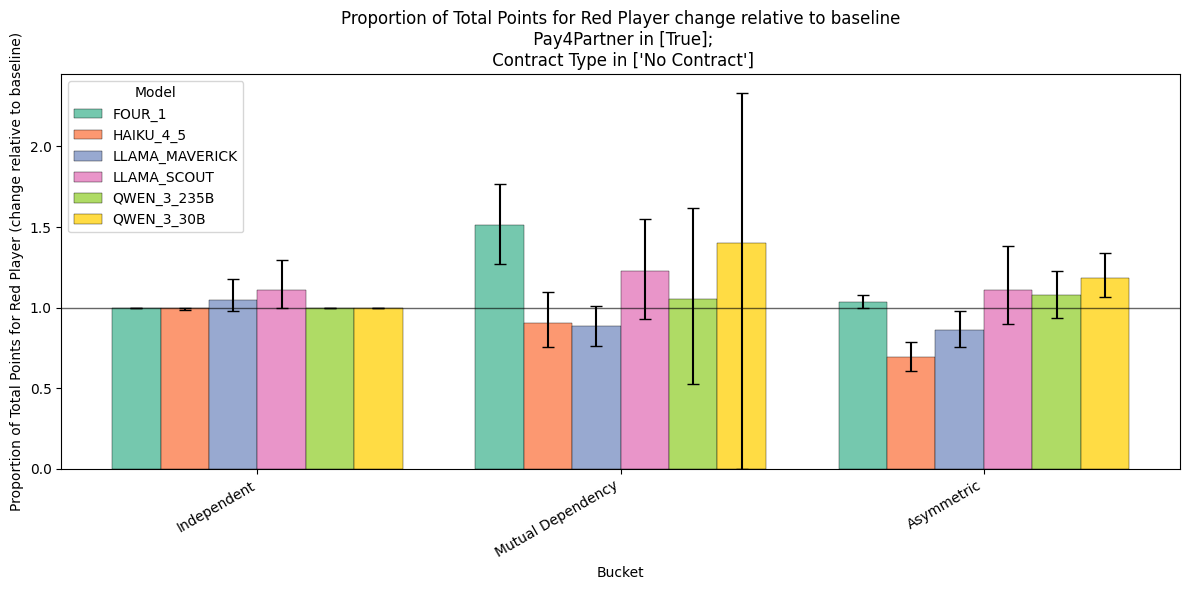

Plotting metric: Percent of Max Score | Contract: Strict Tile | Pay4Partner: True


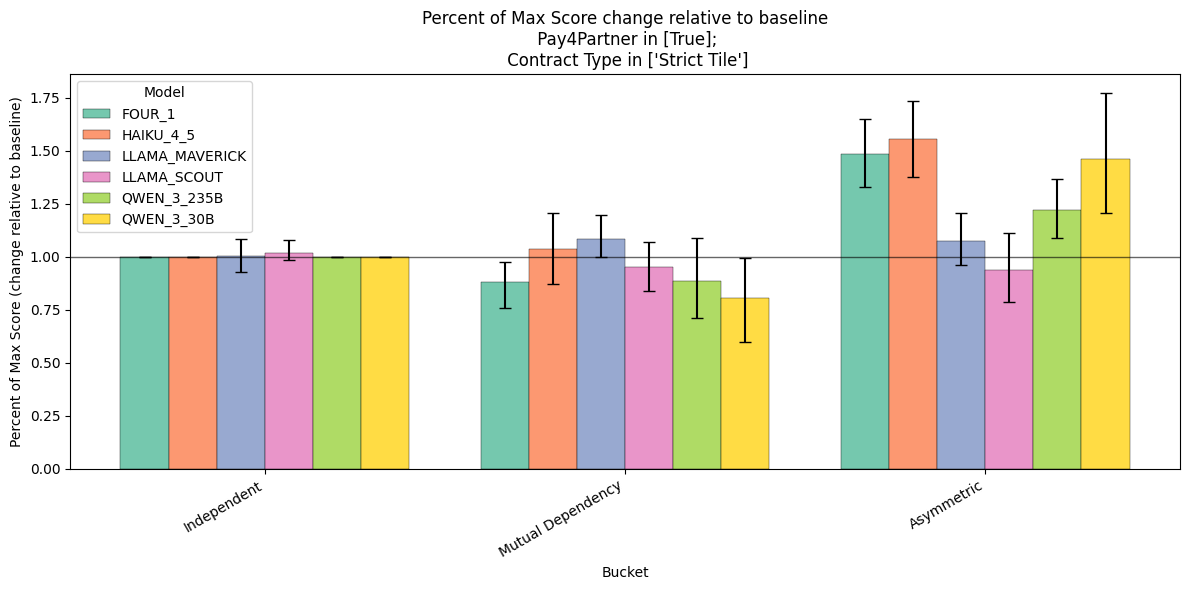

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Tile | Pay4Partner: True


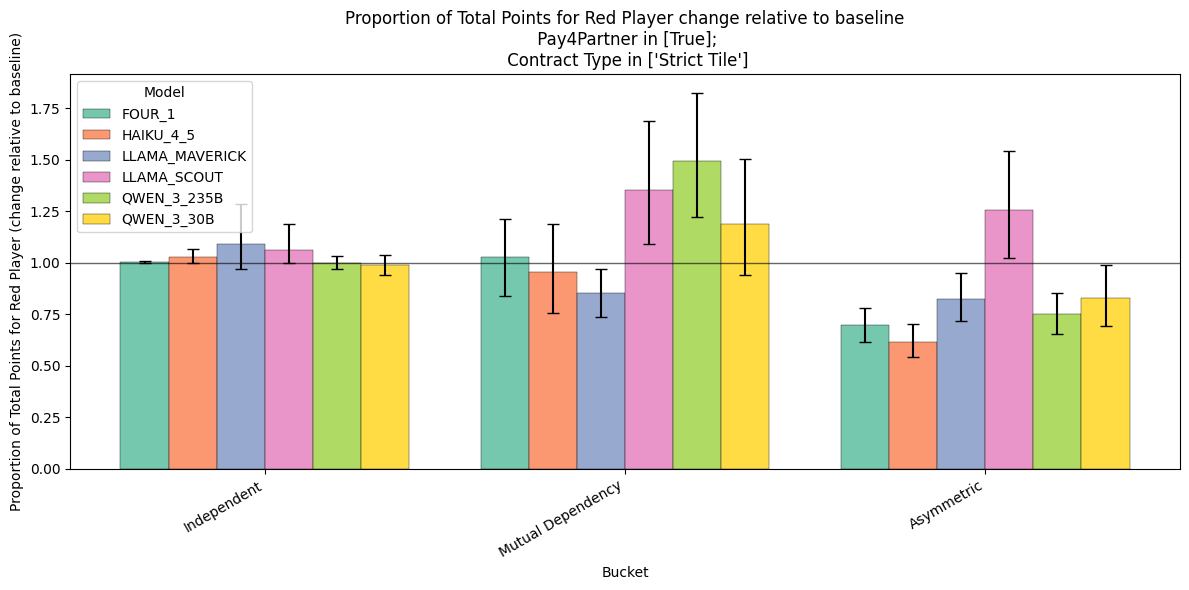

Plotting metric: Percent of Max Score | Contract: Natural Language Tile | Pay4Partner: True


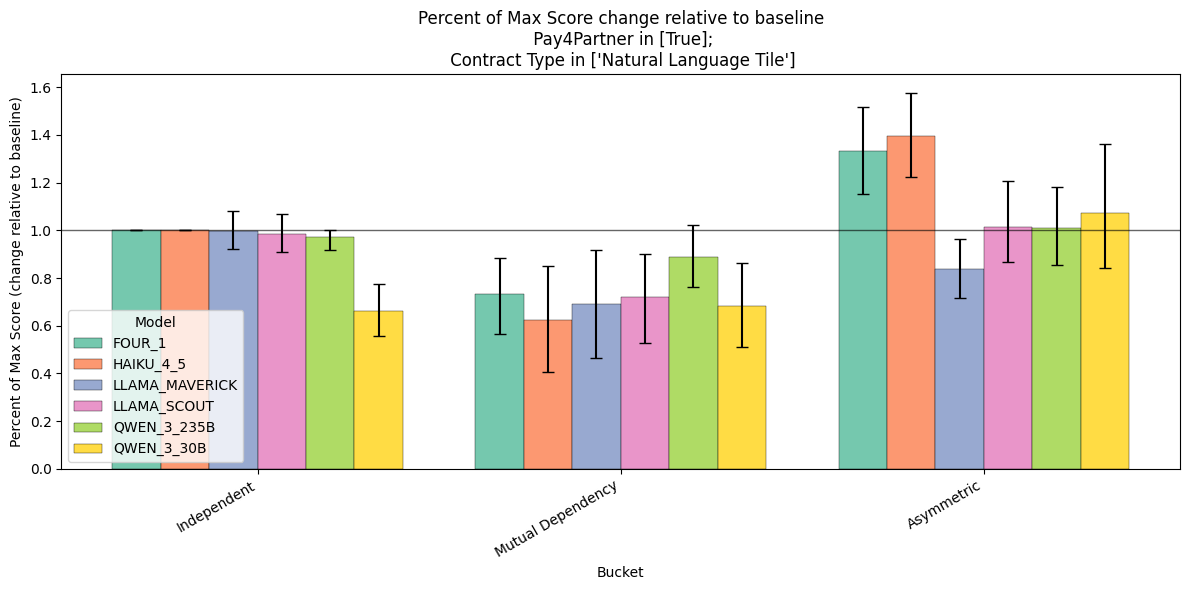

Plotting metric: Proportion of Total Points for Red Player | Contract: Natural Language Tile | Pay4Partner: True


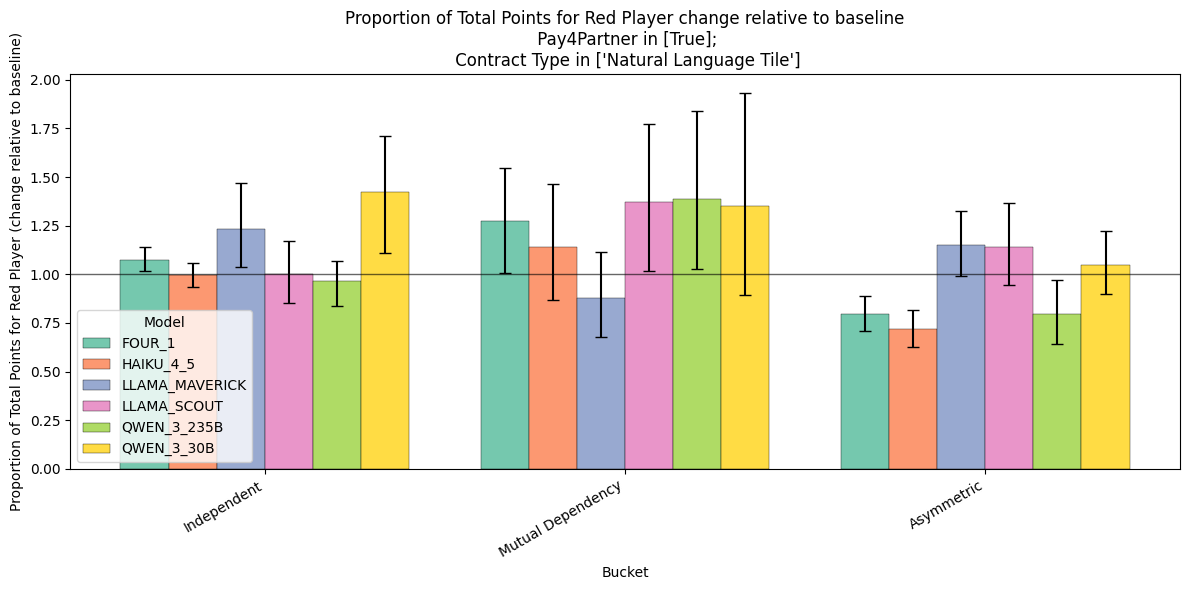

Plotting metric: Percent of Max Score | Contract: Strict Finishing | Pay4Partner: True


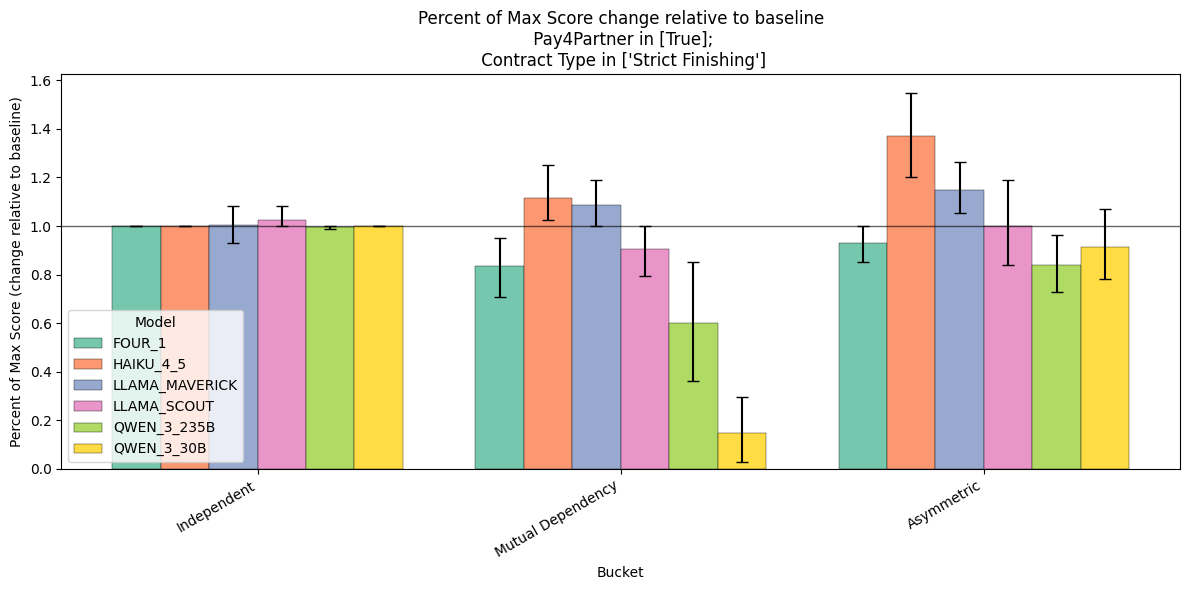

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Finishing | Pay4Partner: True


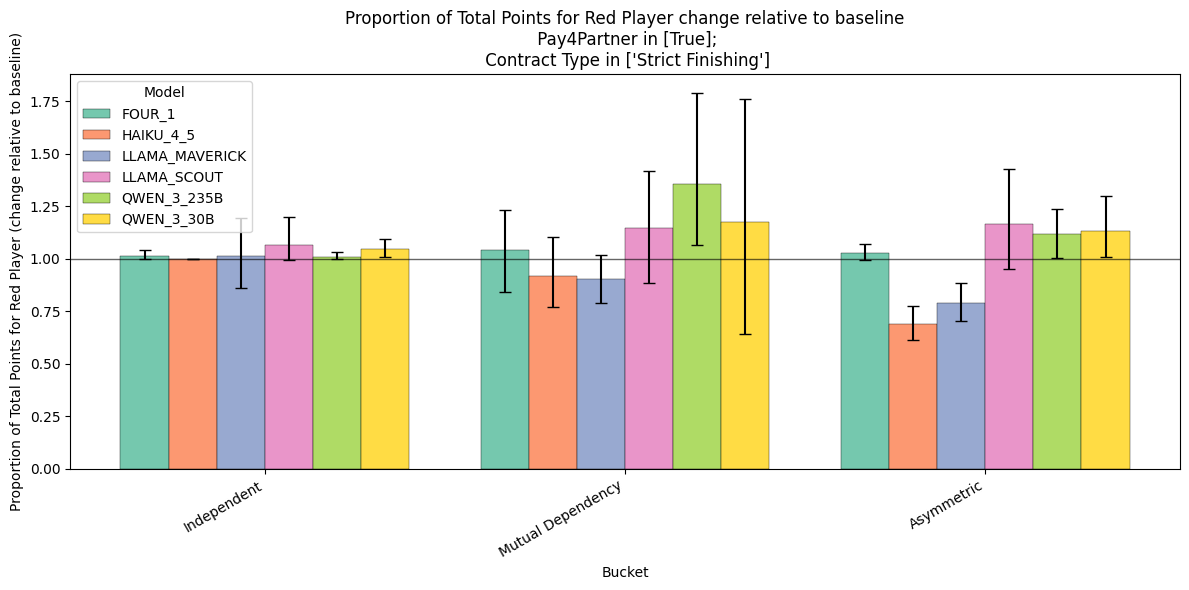

In [ ]:
metrics = [
    'Normalized Total Score',
    'Proportion of Total Points for Red Player',
]

contracts = ['No Contract', 'Strict Tile', 'Natural Language Tile', 'Strict Finishing']
p4p_values = [False, True]

for p4p in p4p_values:
    for contract in contracts:
        if not p4p and contract == 'No Contract':
            continue  # skip baseline
        for metric in metrics:
            print(f"Plotting metric: {metric} | Contract: {contract} | Pay4Partner: {p4p}")
            plot_bootstrap_relative_lift_bar(
                df=df_compared_to_baseline,
                metric=metric,
                x='Bucket',
                hue='Model',
                filters=[
                    ("Pay4Partner", [p4p]),
                    ("Contract Type", [contract]),
                ],
                display_filter=True,
                order=bucket_order,
                hue_order=model_order,
                # ylim=(0, 10),
            )

## Plot Both Beat Baseline for Contracts

Plotting metric: Both Players Beat Baseline


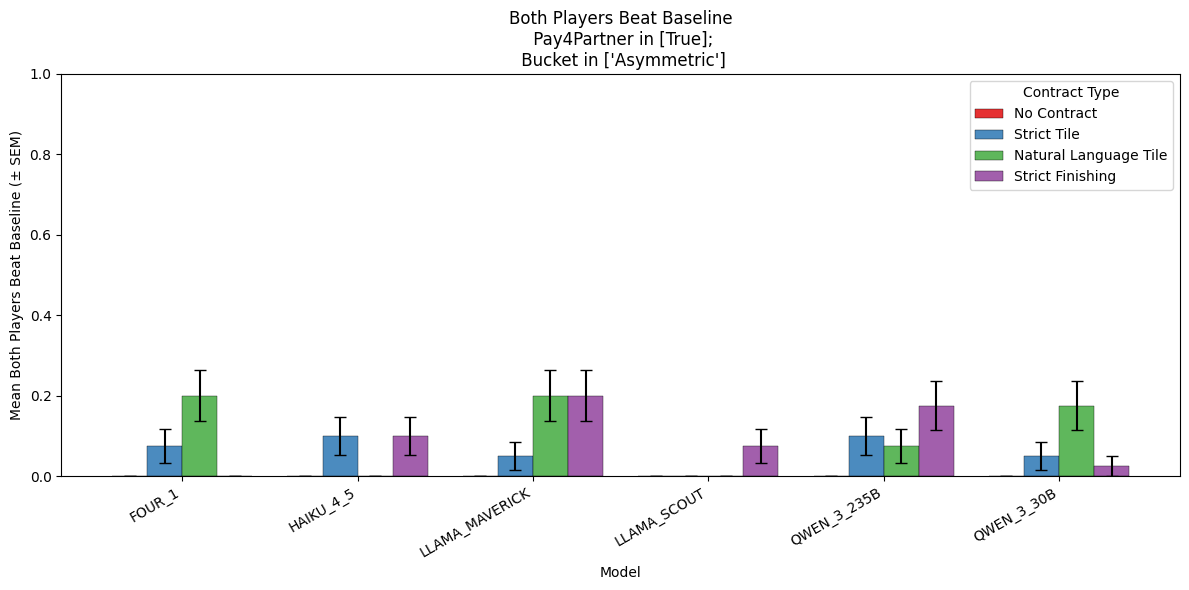

In [62]:
metrics_cfg = [
{'df': df,
    'metric': 'Both Players Beat Baseline',
                 'x': 'Model',
                 'hue': 'Contract Type',
                 'order': model_order,
                 'hue_order': contract_order,
                 'filters':[("Pay4Partner", [True]), 
                ('Bucket', ['Asymmetric'])],
}
]

for metric_cfg in metrics_cfg:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        palette="Set1",
    )

## Per Player Points

/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_96088/1304727900.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Contract Type', 'Model', 'Player'], as_index=False)['Score']
/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_96088/1304727900.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Contract Type', 'Player'], as_index=False)['Score']
/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_96088/1304727900.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

Saved figure to analysis/figures/player_scores_by_contract_for_Asymmetric_boards.pdf


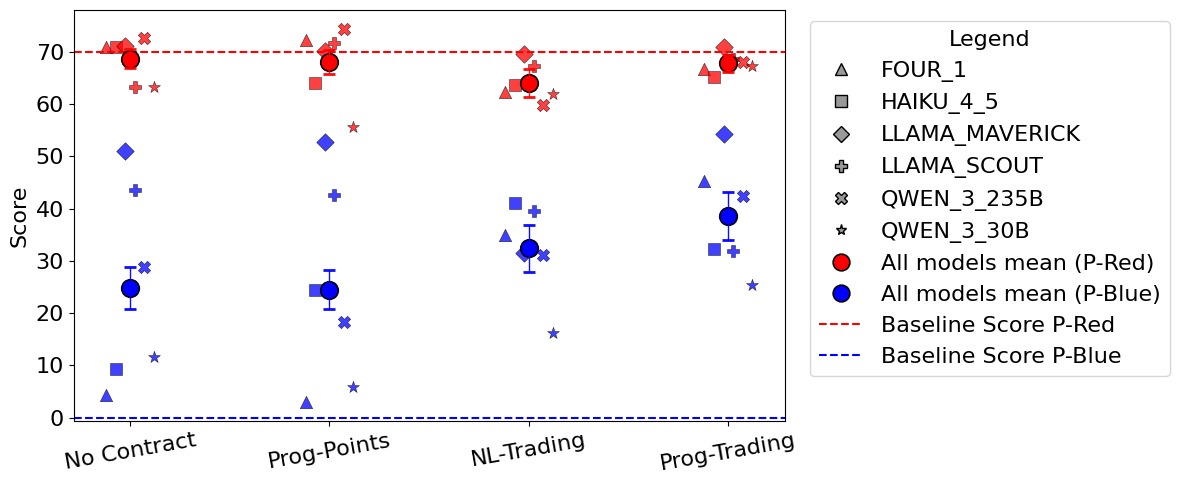

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

RT = df.copy()

bucket = 'Asymmetric'
p4p = False
subset = RT[(RT['Bucket'] == bucket) & (RT['Pay4Partner'] == p4p)].copy()

# Contract order
order = contract_order
subset['Contract Type'] = pd.Categorical(subset['Contract Type'], categories=order, ordered=True)

# Long format
df_long = subset.melt(
    id_vars=['Contract Type', 'Model'],
    value_vars=['Score Player 0', 'Score Player 1'],
    var_name='Player',
    value_name='Score',
)
df_long['Player'] = df_long['Player'].map({'Score Player 0': 'Player 0', 'Score Player 1': 'Player 1'})
player_order = ['Player 0', 'Player 1']

# Collapse to ONE point per (Contract, Model, Player)
model_means = (
    df_long
    .groupby(['Contract Type', 'Model', 'Player'], as_index=False)['Score']
    .mean()
)
model_means['Player'] = pd.Categorical(model_means['Player'], categories=player_order, ordered=True)
model_means = model_means.sort_values(['Contract Type', 'Model', 'Player'])

# Averages across all models (per contract, per player)
avg_long = (
    model_means
    .groupby(['Contract Type', 'Player'], as_index=False)['Score']
    .mean()
)
avg_long['Player'] = pd.Categorical(avg_long['Player'], categories=player_order, ordered=True)
avg_long = avg_long.sort_values(['Contract Type', 'Player'])

avg_stats = (
    df_long
    .groupby(['Contract Type', 'Player'])
    .agg(
        mean_score=('Score', 'mean'),
        sd=('Score', 'std'),
        n=('Score', 'count'),
    )
    .reset_index()
)
avg_stats['sem'] = avg_stats['sd'] / np.sqrt(avg_stats['n'])
avg_stats['Player'] = pd.Categorical(avg_stats['Player'], categories=player_order, ordered=True)
avg_stats['ci95'] = 1.96 * avg_stats['sem']
avg_stats.loc[avg_stats['n'] <= 1, 'ci95'] = 0.0  # CI undefined for n=1; show 0-length bars
avg_stats = avg_stats.sort_values(['Contract Type', 'Player'])


# Baselines
baseline_p0 = subset['Non-Cooperative Baseline Player 0'].mean()
baseline_p1 = subset['Non-Cooperative Baseline Player 1'].mean()

# Models + distinct shapes (NO circles reserved for means)
models = sorted(model_means['Model'].dropna().unique().tolist())
model_markers = ['^', 's', 'D', 'P', 'X', '*', 'v', '<', '>', 'H']  # plenty; no 'o'
if len(models) > len(model_markers):
    raise ValueError(f"Not enough marker shapes for {len(models)} models; add more to model_markers.")

model_to_marker = {m: model_markers[i] for i, m in enumerate(models)}

# Color by player (requested)
player_color = {'Player 0': 'red', 'Player 1': 'blue'}


fig, ax = plt.subplots(figsize=(12, 5))

# Deterministic x positions
xpos = {ct: i for i, ct in enumerate(order)}

# Fixed offsets for models within each contract (evenly spaced)
# Keep within about +/-0.25 so it doesn't spill into neighboring categories.
span = 0.12
offsets = (
    [0.0] if len(models) == 1
    else list(np.linspace(-span, span, num=len(models)))
)
model_to_offset = {m: offsets[i] for i, m in enumerate(models)}

# --- Per-model points: deterministic offsets (replaces jitter) ---
for player in player_order:
    d_player = model_means[model_means['Player'] == player].copy()

    for m in models:
        d = d_player[d_player['Model'] == m].copy()
        if d.empty:
            continue

        # numeric x for each contract with model-specific offset
        xs = d['Contract Type'].map(xpos).to_numpy() + model_to_offset[m]
        ys = d['Score'].to_numpy()

        ax.scatter(
            xs,
            ys,
            s=80,  # matplotlib uses area; roughly match seaborn size=7
            marker=model_to_marker[m],
            c=player_color[player],
            alpha=0.75,
            edgecolors='k',
            linewidths=0.4,
            zorder=2,
        )

# --- Means: big centered circles (no offset) ---

for player in player_order:
    d = avg_stats[avg_stats['Player'] == player].copy()
    xs = d['Contract Type'].map(xpos).to_numpy()
    ys = d['mean_score'].to_numpy()
    yerr = np.nan_to_num(d['ci95'].to_numpy(), nan=0.0)

    # Mean marker
    ax.scatter(
        xs,
        ys,
        s=160,
        marker='o',
        c=player_color[player],
        alpha=1.0,
        edgecolors='k',
        linewidths=1.2,
        zorder=6,
    )

    # Error bars
    ax.errorbar(
        xs,
        ys,
        yerr=yerr,
        fmt='none',
        ecolor=player_color[player],
        elinewidth=1.0,
        capsize=4,
        capthick=2.0,
        alpha=0.95,
        zorder=10,
    )


# Baseline lines
ax.axhline(y=baseline_p0, color='red', linestyle='--', linewidth=1.5, label='Baseline Score P-Red')
ax.axhline(y=baseline_p1, color='blue', linestyle='--', linewidth=1.5, label='Baseline Score P-Blue')

# X axis ticks from numeric positions
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=10, fontsize=DEFAULT_FONT_SIZE)

# ax.set_xlabel('Contract Type')
ax.set_ylabel('Score', fontsize=DEFAULT_FONT_SIZE)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=DEFAULT_FONT_SIZE)
# ax.set_title(f"Player Scores by Contract Type for {bucket} Boards")


# Build custom legend: models (shapes) + means + baselines
legend_handles = []

# Model legend (shape only; use neutral color)
legend_handles += [
    Line2D([0], [0], marker=model_to_marker[m], linestyle='None',
           markerfacecolor='0.6', markeredgecolor='k', markersize=8, label=m)
    for m in models
]

# (Removed) Color legend for players — red/blue in plot is already obvious

# Mean legend (bigger circles)
legend_handles += [
    Line2D([0], [0], marker='o', linestyle='None', color=player_color['Player 0'],
           markerfacecolor=player_color['Player 0'], markeredgecolor='k',
           markeredgewidth=1.2, markersize=12, label='All models mean (P-Red)'),
    Line2D([0], [0], marker='o', linestyle='None', color=player_color['Player 1'],
           markerfacecolor=player_color['Player 1'], markeredgecolor='k',
           markeredgewidth=1.2, markersize=12, label='All models mean (P-Blue)'),
]

# Baselines
legend_handles += [
    Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='Baseline Score P-Red'),
    Line2D([0], [0], color='blue', linestyle='--', linewidth=1.5, label='Baseline Score P-Blue'),
]

ax.legend(handles=legend_handles, title='Legend', bbox_to_anchor=(1.02, 1), loc='upper left',
          fontsize=DEFAULT_FONT_SIZE,      # legend text
    title_fontsize=DEFAULT_FONT_SIZE)
name = f'player_scores_by_contract_for_{bucket}_boards'
output_path = f"{output_folder}/{name}.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
print(f"Saved figure to {output_path}")

plt.tight_layout()
plt.show()

## Other metrics

In [ ]:
contract_order = ['No Contract', 'Strict Finishing', 'Natural Language Tile', 'Strict Tile',   ]

In [74]:
subset = df[(df["Bucket"] == bucket) 
            & (df["Pay4Partner"] == False) 
            # & (df["Contract Type"].isin(contracts))
            ].copy()

subset.groupby('total_trade_volume')['Run ID'].count()

total_trade_volume
0     133
2       8
3      10
4     107
5      87
6      40
7      23
8      17
9      14
10     14
11      9
12      4
13      2
14      2
15      2
16      4
18      1
20      1
22      2
Name: Run ID, dtype: int64

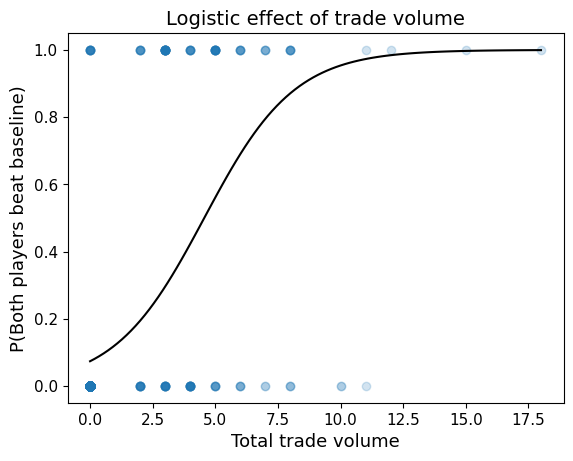

In [ ]:
# import numpy as np
# from sklearn.linear_model import LogisticRegression

# bucket = 'Asymmetric'
# contracts = ['Strict Finishing', 'Natural Language Tile']

# subset = df[(df["Bucket"] == bucket) 
#             & (df["Pay4Partner"] == False) 
#             & (df["Contract Type"].isin(contracts))
#             & (df['contract_accepted'] == 1)
#             ].copy()


# # X must be 2D
# X = subset[["total_trade_volume"]].values
# y = subset["Both Players Beat Baseline"].values

# model = LogisticRegression(solver="lbfgs")
# model.fit(X, y)

# import matplotlib.pyplot as plt

# x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
# p_vals = model.predict_proba(x_vals)[:, 1]

# plt.scatter(X, y, alpha=0.2)
# plt.plot(x_vals, p_vals, color="black")
# plt.xlabel("Total trade volume")
# plt.ylabel("P(Both players beat baseline)")
# plt.title("Logistic effect of trade volume")
# plt.show()

In [ ]:
# beta = model.coef_[0][0]
# odds_ratio = np.exp(beta)

# print(f"β (log-odds per chip): {beta:.3f}")
# print(f"Odds ratio per chip: {odds_ratio:.3f}")

β (log-odds per chip): 0.556
Odds ratio per chip: 1.744


In [122]:
contracts = ['Strict Tile', 'Natural Language Tile']
bucket = 'Asymmetric'
subset = df[(df["Bucket"] == bucket) 
            & (df["Pay4Partner"] == False) 
            & (df["Contract Type"].isin(contracts))
            # & (df['contract_accepted'] == 1)
            ].copy()


p_bbb_w_trades = subset[subset['total_trade_volume'] > 0]['Both Players Beat Baseline'].mean()
p_bbb_wo_trades = subset[subset['total_trade_volume'] == 0]['Both Players Beat Baseline'].mean()
print(f"P(Both Beat Baseline | trades > 0) = {p_bbb_w_trades:.3f}")
print(f"P(Both Beat Baseline | trades = 0) = {p_bbb_wo_trades:.3f}")

P(Both Beat Baseline | trades > 0) = 0.462
P(Both Beat Baseline | trades = 0) = 0.047


In [124]:
p_blue_finished = subset[subset['total_trade_volume'] > 0]['R_beats_baseline'].mean()
p_finished = subset[subset['total_trade_volume'] == 0]['R_beats_baseline'].mean()
print(f"P(Red Beats baseline | trades > 0) = {p_blue_finished:.3f}")
print(f"P(Red Beats baseline| trades = 0) = {p_finished:.3f}")



P(Red Beats baseline | trades > 0) = 0.564
P(Red Beats baseline| trades = 0) = 0.121


In [123]:
p_blue_finished = subset[subset['total_trade_volume'] > 0]['Reached Goal Player 1'].mean()
p_finished = subset[subset['total_trade_volume'] == 0]['Reached Goal Player 1'].mean()
print(f"P(Blue finishes | trades > 0) = {p_blue_finished:.3f}")
print(f"P(Blue finises | trades = 0) = {p_finished:.3f}")



P(Blue finishes | trades > 0) = 0.838
P(Blue finises | trades = 0) = 0.388


In [112]:
df[df['contract_accepted'] == 0].shape

(1376, 115)

β (log-odds per chip): 0.556
Odds ratio per chip: 1.744


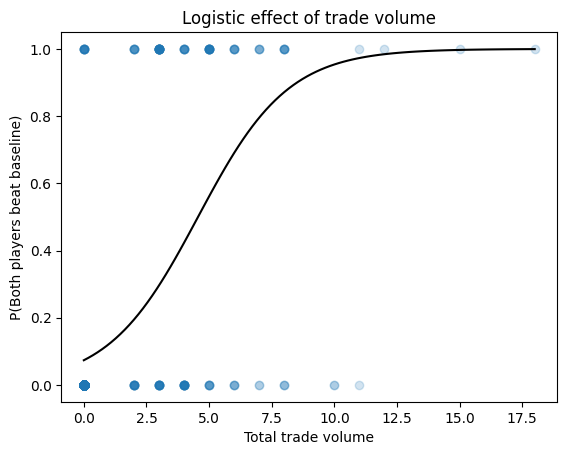

In [ ]:
df

Obviously trading is a strong predictor of success when there are no contracts, but even when there are contracts?

In [96]:
import statsmodels.api as sm

X_sm = sm.add_constant(subset["total_trade_volume"])
y_sm = subset["Both Players Beat Baseline"]

model_sm = sm.Logit(y_sm, X_sm).fit()
print(model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.355116
         Iterations 6
                               Logit Regression Results                               
Dep. Variable:     Both Players Beat Baseline   No. Observations:                  480
Model:                                  Logit   Df Residuals:                      478
Method:                                   MLE   Df Model:                            1
Date:                        Tue, 27 Jan 2026   Pseudo R-squ.:                  0.2777
Time:                                17:16:17   Log-Likelihood:                -170.46
converged:                               True   LL-Null:                       -235.98
Covariance Type:                    nonrobust   LLR p-value:                 2.428e-30
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.545

On how many boards does each contract type come out on top? (or tied first)
Treat three buckets independently
What do we mean by come out on top:
Normalised total score 
Asymmetric: both beat baseline 
m


## Which contract is best?

In [11]:
df = format_data(full_df)
p4p = False
bucket = ['Mutual Dependency', ]
subset = df[
    (df["Bucket"].isin(bucket)) &
    (df["Pay4Partner"] == p4p)
].copy()

print(f"{len(subset)} rows after filtering; {subset['Grid ID'].nunique()} grids")

# We want one row per (Grid ID, Contract Type) with aggregated metrics.
# Here I take the mean per grid+contract; adjust agg if needed.
agg = (
    subset
    .groupby(["Grid ID", "Contract Type"], as_index=False)
    .agg(
        norm_total_score=("Normalized Total Score", "mean"),
        both_beat_baseline=("Both Players Beat Baseline", "mean"),  # proportion in [0,1]
    )
)

# ---- Rank contracts within each grid for each metric ----
# Higher is better, so use ascending=False. Rank 1 = best.
agg["rank_norm_score"] = agg.groupby("Grid ID")["norm_total_score"] \
                            .rank(method="min", ascending=False)
agg["rank_both_beat"] = agg.groupby("Grid ID")["both_beat_baseline"] \
                           .rank(method="min", ascending=False)

# Optional: keep only integer ranks (they will be floats from rank())
agg["rank_norm_score"] = agg["rank_norm_score"].astype(int)
agg["rank_both_beat"] = agg["rank_both_beat"].astype(int)

print("Per-grid, per-contract rankings (head):")
display(agg.head())

# ---- How often each contract is 1st / 2nd / 3rd / ... for each metric? ----
# For Normalized Total Score
rank_counts_norm = (
    agg
    .groupby(["Contract Type", "rank_norm_score"])
    .size()
    .reset_index(name="count")
    .pivot(index="Contract Type", columns="rank_norm_score", values="count")
    .fillna(0)
    .astype(int)
    .rename_axis(columns="Rank (1=best)")
)

print("\nHow often each contract is 1st / 2nd / 3rd / ... by Normalized Total Score:")
display(rank_counts_norm)

# For Both Players Beat Baseline (actually proportion across games in that grid+contract)
rank_counts_both = (
    agg
    .groupby(["Contract Type", "rank_both_beat"])
    .size()
    .reset_index(name="count")
    .pivot(index="Contract Type", columns="rank_both_beat", values="count")
    .fillna(0)
    .astype(int)
    .rename_axis(columns="Rank (1=best)")
)

print("\nHow often each contract is 1st / 2nd / 3rd / ... by Both Players Beat Baseline:")
display(rank_counts_both)


Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows
480 rows after filtering; 20 grids
Per-grid, per-contract rankings (head):


,Grid ID,Contract Type,norm_total_score,both_beat_baseline,rank_norm_score,rank_both_beat
0,80,NL-Trading,0.333333,0.333333,4,4
1,80,No Contract,0.916667,0.833333,3,3
2,80,Prog-Points,1.000000,1.000000,1,1
3,80,Prog-Trading,1.000000,1.000000,1,1
4,81,NL-Trading,0.613095,0.333333,4,4



How often each contract is 1st / 2nd / 3rd / ... by Normalized Total Score:


Rank (1=best),1,2,3,4
Contract Type,,,,
NL-Trading,0,1,2,17
No Contract,11,4,4,1
Prog-Points,15,3,2,0
Prog-Trading,5,3,10,2



How often each contract is 1st / 2nd / 3rd / ... by Both Players Beat Baseline:


Rank (1=best),1,2,3,4
Contract Type,,,,
NL-Trading,0,0,6,14
No Contract,10,6,3,1
Prog-Points,20,0,0,0
Prog-Trading,4,6,9,1


Within models there is a lot of noise making it difficult to observe which contract types perform best. However by aggregating across models and looking at which contract type performs best on each grid, the quality of different models becomes more clear. For mutual dependency boards the Strict Finishing contract results in the highest average Normalized Total Score across all contract types in 15 of the 20 grids. For asymmetric boards the Strict Finishing contract results in the highest average Both Beat Baseline Score across all contract types in 26 of the 40 grids. Meanwhile the Strict Tile was the best performing for Normalized Total Score, performing the best in 23 of the 40 grids.

Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows
480 rows after filtering; 20 grids


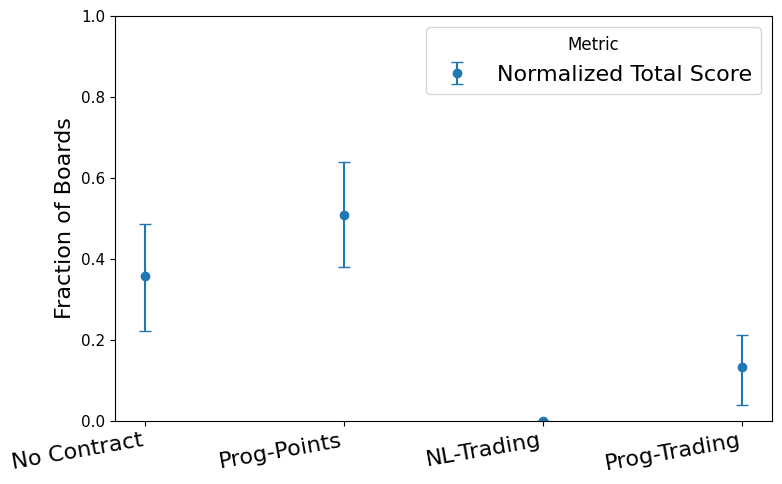

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = format_data(full_df)
p4p = False
bucket = ['Mutual Dependency', ]
subset = df[
    df["Bucket"].isin(bucket) &
    (df["Pay4Partner"] == p4p)
].copy()


print(f"{len(subset)} rows after filtering; {subset['Grid ID'].nunique()} grids")

# One row per (Grid ID, Contract Type) with aggregated metrics.
agg = (
    subset
    .groupby(["Grid ID", "Contract Type"], as_index=False)
    .agg(
        norm_total_score=("Normalized Total Score", "mean"),
        all_beat_baseline=("All Beat Baseline", "mean"),
    )
)

# ----- fractional "best" indicators per grid, per contract, per metric -----
# Normalized Total Score
g_norm = agg.groupby("Grid ID")["norm_total_score"]
max_norm = g_norm.transform("max")
n_top_norm = g_norm.transform(lambda s: (s == s.max()).sum())

agg["best_norm_score"] = 0.0
mask_top_norm = agg["norm_total_score"] == max_norm
agg.loc[mask_top_norm, "best_norm_score"] = 1.0 / n_top_norm[mask_top_norm]

# all Players Beat Baseline
g_all = agg.groupby("Grid ID")["all_beat_baseline"]
max_all = g_all.transform("max")
n_top_all = g_all.transform(lambda s: (s == s.max()).sum())

agg["best_all_beat"] = 0.0
mask_top_all = agg["all_beat_baseline"] == max_all
agg.loc[mask_top_all, "best_all_beat"] = 1.0 / n_top_all[mask_top_all]

# Long format over metrics so we can easily use hue
agg_long = agg.melt(
    id_vars=["Grid ID", "Contract Type"],
    value_vars=["best_norm_score", "best_all_beat"],
    var_name="Metric",
    value_name="best_mass",
)
metric_map = {
    "best_norm_score": "Normalized Total Score",
    "best_all_beat": "All Beat Baseline",
}
agg_long["Metric"] = agg_long["Metric"].map(metric_map)
if bucket != ['Asymmetric']:
    agg_long = agg_long[agg_long["Metric"] == "Normalized Total Score"]

# ----- bootstrap over grids for CIs -----
rng = np.random.default_rng(0)
n_boot = 5000

grid_ids = agg_long["Grid ID"].unique()
n_grids = len(grid_ids)

# Prepare structure: we'll accumulate bootstrap means in a dict keyed by (contract, metric)
boot_means = {}

contracts = sorted(agg_long["Contract Type"].unique())
metrics = sorted(agg_long["Metric"].unique())

for contract in contracts:
    for metric in metrics:
        key = (contract, metric)
        boot_means[key] = np.empty(n_boot, dtype=float)

for b in range(n_boot):
    # sample grids with replacement
    sampled_grids = rng.choice(grid_ids, size=n_grids, replace=True)
    boot_sample = agg_long[agg_long["Grid ID"].isin(sampled_grids)].copy()

    # average best_mass across sampled grids for each (Contract Type, Metric)
    means = (
        boot_sample
        .groupby(["Contract Type", "Metric"], as_index=False)["best_mass"]
        .mean()
    )
    for _, row in means.iterrows():
        key = (row["Contract Type"], row["Metric"])
        boot_means[key][b] = row["best_mass"]

# Summarize bootstrap means: overall mean + 95% CI
rows = []
for contract in contracts:
    for metric in metrics:
        vals = boot_means[(contract, metric)]
        mean_val = np.nanmean(vals)
        lo, hi = np.nanpercentile(vals, [2.5, 97.5])
        rows.append(
            dict(
                Contract_Type=contract,
                Metric=metric,
                mean_best=mean_val,
                ci_lower=lo,
                ci_upper=hi,
            )
        )

summary = pd.DataFrame(rows)
order = contract_order
# keep only those present, in that order
x_order = [c for c in order if c in summary["Contract_Type"].unique()]

summary["Contract_Type"] = pd.Categorical(
    summary["Contract_Type"],
    categories=x_order,
    ordered=True,
)

# ----- plot: contracts on x, metrics as hue, bootstrap CIs as error bars -----
plt.figure(figsize=(8, 5))

hue_order = metrics  # e.g. ["Normalized Total Score"] or both

n_metrics = len(hue_order)

for i, metric in enumerate(hue_order):
    d = summary[summary["Metric"] == metric].copy().set_index("Contract_Type")
    d = d.loc[x_order]  # ensure correct order

    # Center when only one metric, side-by-side when two
    if n_metrics == 1:
        offset = 0.0
    else:
        offset = -0.15 + i * (0.30 / (n_metrics - 1))

    xs = np.arange(len(x_order)) + offset

    plt.errorbar(
        xs,
        d["mean_best"],
        yerr=[
            d["mean_best"] - d["ci_lower"],
            d["ci_upper"] - d["mean_best"],
        ],
        fmt="o",
        label=metric,
        capsize=4,
        elinewidth=1.5,
    )

plt.ylim(0, 1.0)
plt.xticks(
    np.arange(len(x_order)),
    x_order,
    rotation=10,
    ha="right",
    fontsize=16,
)
plt.ylabel("Fraction of Boards", fontsize=16)
plt.legend(title="Metric", fontsize=16)
plt.tight_layout()
plt.savefig(
    f"{output_folder}/contract_best_fraction_by_metric_{bucket}_p4p_{p4p}.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

Plotting rank 1 counts for metric: norm_total_score, buckets=['Asymmetric'], Pay4Partner=False


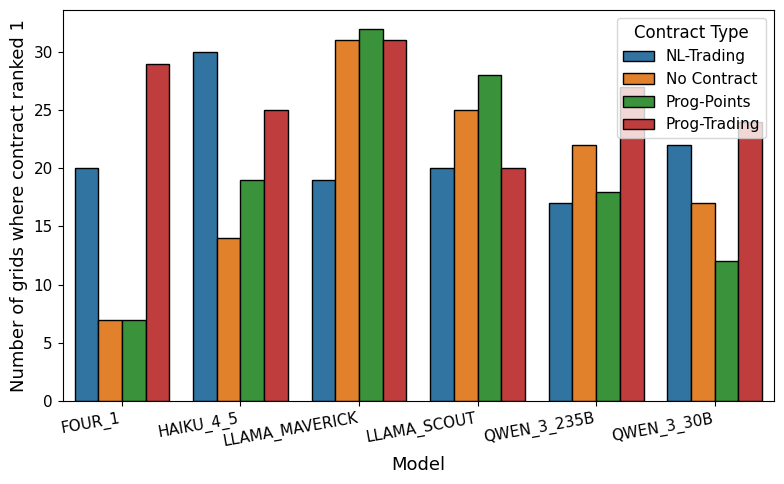

Plotting rank 1 counts for metric: both_beat_baseline, buckets=['Asymmetric'], Pay4Partner=False


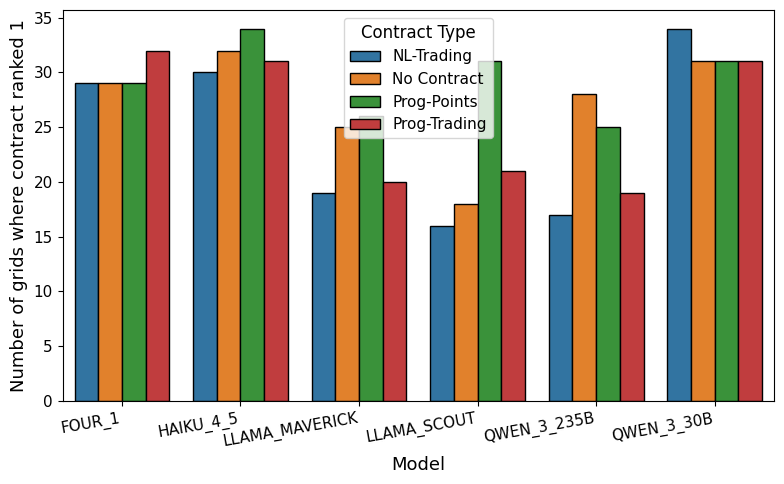

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

def compute_contract_ranks(df, buckets, p4p=False):
    subset = df[
        df["Bucket"].isin(buckets) &
        (df["Pay4Partner"] == p4p)
    ].copy()

    agg = (
        subset
        .groupby(["Grid ID", "Contract Type", "Model"], as_index=False)
        .agg(
            norm_total_score=("Normalized Total Score", "mean"),
            both_beat_baseline=("Both Players Beat Baseline", "mean"),
        )
    )

    # Rank within each (Grid ID, Model)
    agg["rank_norm_score"] = agg.groupby(["Grid ID", "Model"])["norm_total_score"] \
                                .rank(method="min", ascending=False)
    agg["rank_both_beat"] = agg.groupby(["Grid ID", "Model"])["both_beat_baseline"] \
                               .rank(method="min", ascending=False)

    agg["rank_norm_score"] = agg["rank_norm_score"].astype(int)
    agg["rank_both_beat"] = agg["rank_both_beat"].astype(int)
    return agg


def plot_rank1_counts(agg, metric="norm_total_score", title_suffix=""):
    """
    agg: output of compute_contract_ranks
    metric: "norm_total_score" or "both_beat_baseline"
    """
    
    rank_col = "rank_norm_score" if metric == "norm_total_score" else "rank_both_beat"

    # Keep only rank 1 per (Grid ID, Model, Contract Type)
    top = agg[agg[rank_col] == 1].copy()

    # Count how many times each (Model, Contract Type) is ranked 1
    counts = (
        top
        .groupby(["Model", "Contract Type"], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=counts,
        x="Model",
        y="count",
        hue="Contract Type",
        edgecolor="k",
    )
    plt.ylabel("Number of grids where contract ranked 1")
    # xlabel = "Contract Type"
    # plt.xlabel(xlabel)

    metric_label = "Normalized Total Score" if metric == "norm_total_score" else "Both Players Beat Baseline"
    # plt.title(f"How often each contract is ranked 1\nMetric: {metric_label}{title_suffix}")
    plt.xticks(rotation=10, ha="right")
    plt.savefig(
        f"{output_folder}/model_level_contract_ranks_{metric}.pdf",
        format="pdf",
        bbox_inches="tight")
    plt.tight_layout()
    plt.show()


# Example usage for your current filter:
buckets = ["Asymmetric"]
p4p = False

agg_with_model = compute_contract_ranks(df, buckets=buckets, p4p=p4p)

metric = "norm_total_score"
print(f"Plotting rank 1 counts for metric: {metric}, buckets={buckets}, Pay4Partner={p4p}")
# Plot for Normalized Total Score
plot_rank1_counts(
    agg_with_model,
    metric=metric,
    title_suffix=f" | Buckets={buckets}, Pay4Partner={p4p}"
)

# Plot for Both Players Beat Baseline
metric="both_beat_baseline"
print(f"Plotting rank 1 counts for metric: {metric}, buckets={buckets}, Pay4Partner={p4p}")
plot_rank1_counts(
    agg_with_model,
    metric=metric,
    title_suffix=f" | Buckets={buckets}, Pay4Partner={p4p}"
)

In [25]:
contract_order

['No Contract', 'Prog-Points', 'NL-Trading', 'Prog-Trading']

## Why is Natural Language so Bad?

In [26]:
df[df['Bucket'] ==  'Mutual Dependency'].groupby('Contract Type')['Normalized Total Score'].mean().reindex(contract_order)

Contract Type
No Contract     0.809673
Prog-Points     0.843155
NL-Trading      0.655060
Prog-Trading    0.869792
Name: Normalized Total Score, dtype: float64

Saved figure to analysis/figures/normalized_total_score_by_contract_for_Mutual Dependency_boards.pdf


/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_90597/2123982260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Contract Type', 'Model'], as_index=False)[metric_col]
/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_90597/2123982260.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Contract Type'])
/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_90597/2123982260.py:78: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  

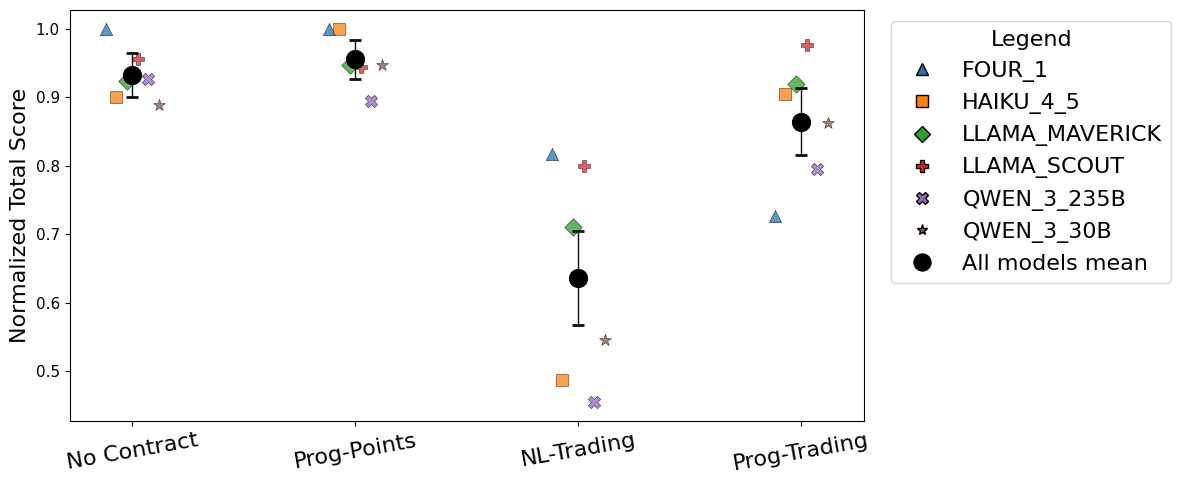

In [28]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

RT = df.copy()

bucket = 'Mutual Dependency'
p4p = False
subset = RT[(RT['Bucket'] == bucket) & (RT['Pay4Partner'] == p4p)].copy()

# Contract order
order = contract_order
subset['Contract Type'] = pd.Categorical(subset['Contract Type'], categories=order, ordered=True)

metric_col = "Normalized Total Score"

# Per-model means: ONE point per (Contract, Model)
model_means = (
    subset
    .groupby(['Contract Type', 'Model'], as_index=False)[metric_col]
    .mean()
    .rename(columns={metric_col: 'Score'})
)

# Overall mean across models per contract + CI across datapoints
avg_stats = (
    subset
    .groupby(['Contract Type'])
    .agg(
        mean_score=(metric_col, 'mean'),
        sd=(metric_col, 'std'),
        n=(metric_col, 'count'),
    )
    .reset_index()
)
avg_stats['sem'] = avg_stats['sd'] / np.sqrt(avg_stats['n'])
avg_stats['ci95'] = 1.96 * avg_stats['sem']
avg_stats.loc[avg_stats['n'] <= 1, 'ci95'] = 0.0
avg_stats = avg_stats.sort_values('Contract Type')

# Models + distinct shapes (NO circles reserved for means)
models = sorted(model_means['Model'].dropna().unique().tolist())
model_markers = ['^', 's', 'D', 'P', 'X', '*', 'v', '<', '>', 'H']
if len(models) > len(model_markers):
    raise ValueError(f"Not enough marker shapes for {len(models)} models; add more to model_markers.")

model_to_marker = {m: model_markers[i] for i, m in enumerate(models)}

# Color palette: one color per model
palette = sns.color_palette("tab10", n_colors=len(models))
model_to_color = {m: palette[i] for i, m in enumerate(models)}

mean_color = "black"

fig, ax = plt.subplots(figsize=(12, 5))

# Deterministic x positions
xpos = {ct: i for i, ct in enumerate(order)}

# Fixed offsets for models within each contract (evenly spaced)
span = 0.12
offsets = (
    [0.0] if len(models) == 1
    else list(np.linspace(-span, span, num=len(models)))
)
model_to_offset = {m: offsets[i] for i, m in enumerate(models)}

# --- Per-model points: deterministic offsets ---
for m in models:
    d = model_means[model_means['Model'] == m].copy()
    if d.empty:
        continue

    xs = d['Contract Type'].map(xpos).to_numpy() + model_to_offset[m]
    ys = d['Score'].to_numpy()

    ax.scatter(
        xs,
        ys,
        s=80,
        marker=model_to_marker[m],
        c=model_to_color[m],
        alpha=0.75,
        edgecolors='k',
        linewidths=0.4,
        zorder=2,
    )

# --- Means: big centered circles (no offset) with 95% CI ---
d = avg_stats.copy()
xs = d['Contract Type'].map(xpos).to_numpy()
ys = d['mean_score'].to_numpy()
yerr = np.nan_to_num(d['ci95'].to_numpy(), nan=0.0)

# Mean marker
ax.scatter(
    xs,
    ys,
    s=160,
    marker='o',
    c=mean_color,
    alpha=1.0,
    edgecolors='k',
    linewidths=1.2,
    zorder=6,
)

# Error bars
ax.errorbar(
    xs,
    ys,
    yerr=yerr,
    fmt='none',
    ecolor=mean_color,
    elinewidth=1.0,
    capsize=4,
    capthick=2.0,
    alpha=0.95,
    zorder=10,
)

# X axis ticks from numeric positions
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=10, fontsize=DEFAULT_FONT_SIZE)

ax.set_ylabel('Normalized Total Score', fontsize=DEFAULT_FONT_SIZE)


legend_handles = []

legend_handles += [
    Line2D(
        [0], [0],
        marker=model_to_marker[m],
        linestyle='None',
        markerfacecolor=model_to_color[m],
        markeredgecolor='k',
        markersize=8,
        label=m,
    )
    for m in models
]

legend_handles += [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        color=mean_color,
        markerfacecolor=mean_color,
        markeredgecolor='k',
        markeredgewidth=1.2,
        markersize=12,
        label='All models mean',
    ),
]

ax.legend(
    handles=legend_handles,
    title='Legend',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=DEFAULT_FONT_SIZE,
    title_fontsize=DEFAULT_FONT_SIZE,
)

name = f'normalized_total_score_by_contract_for_{bucket}_boards'
output_path = f"{output_folder}/{name}.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
print(f"Saved figure to {output_path}")

plt.tight_layout()
plt.show()

Plotting metric: total_trade_volume


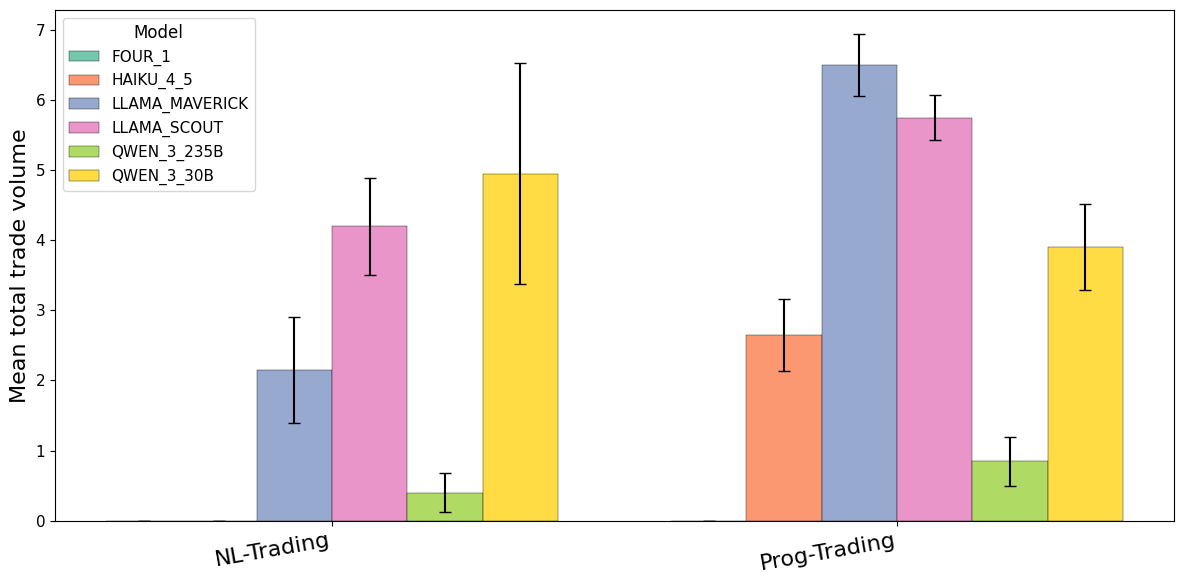

Plotting metric: moves_made_under_strict_contract_total


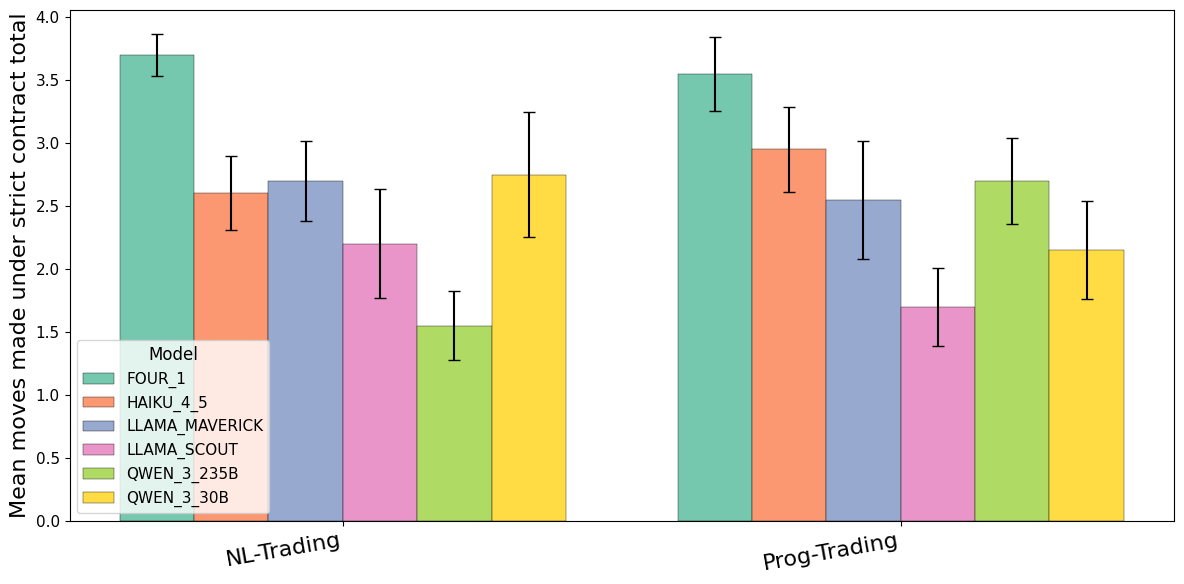

In [18]:
core_metrics = [
{'df': df,
    'metric': 'total_trade_volume',
                 'x': 'Contract Type',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['Prog-Trading', 'NL-Trading']),
                ('Bucket', ['Mutual Dependency'])],
},
{'df': df,
    'metric': 'moves_made_under_strict_contract_total',
                 'x': 'Contract Type',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['Prog-Trading', 'NL-Trading']),
                ('Bucket', ['Mutual Dependency'])],
},
]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=None
        
    )

In [71]:
df[(df['Bucket'] ==  'Mutual Dependency')
   & (df['Pay4Partner'] == False)
   
   ].groupby('Contract Type')[['Normalized Total Score','moves_made_under_strict_contract_total', 'Total Trades Proposed', 
                               'total_trade_acceptance_rate',
                               'total_trade_volume']].mean()

,Normalized Total Score,moves_made_under_strict_contract_total,Total Trades Proposed,total_trade_acceptance_rate,total_trade_volume
Contract Type,,,,,
Natural Language Tile,0.636310,2.583333,1.541667,0.403578,1.950000
No Contract,0.932440,0.000000,3.708333,0.632128,6.125000
Strict Finishing,0.955357,0.000000,3.258333,0.660374,6.058333
Strict Tile,0.864286,2.600000,2.825000,0.396096,3.275000


## Bad Trades

Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows
Plotting metric: Bad Trade


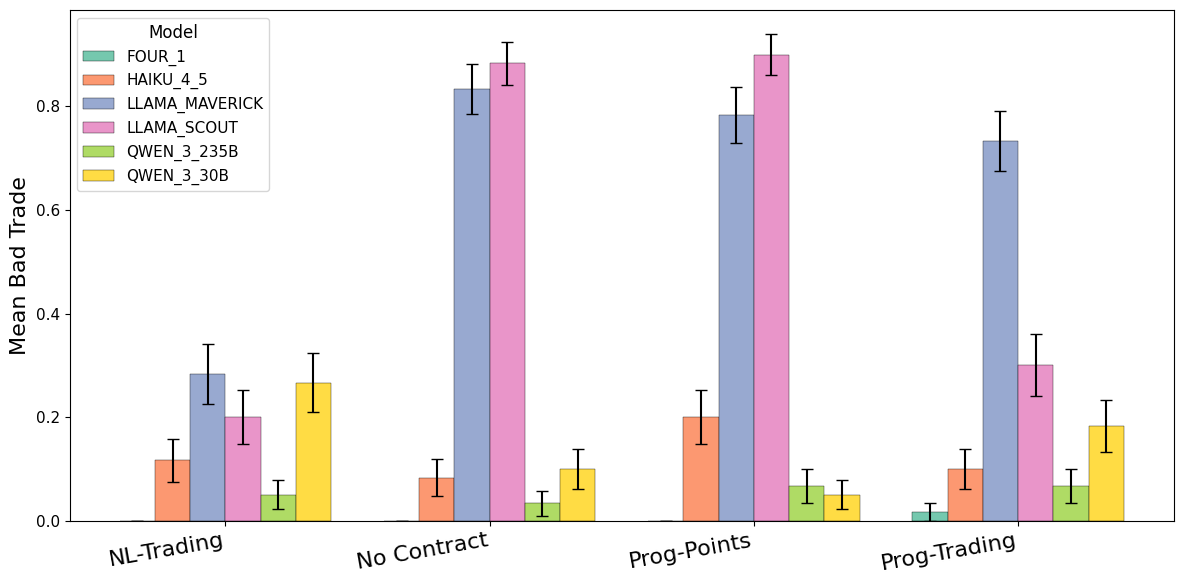

In [19]:
df = format_data(full_df)
core_metrics = [
{'df': df,
    'metric': 'Bad Trade',
                 'x': 'Contract Type',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                # ('Contract Type', ['Strict Tile', 'Natural Language Tile']),
                ('Bucket', ['Independent', 'Asymmetric'])],
},
]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=None
        
    )

## Summaries

### Summary fn

In [13]:

import numpy as np
import pandas as pd

def print_model_metric_summaries(
    df: pd.DataFrame,
    metrics: list[str],
    p4p: list[bool] | None = None,
    contract_types: list[str] | None = None,
    buckets: list[str] | None = None,
    model_col: str = "Model",
):
    """
    For each model, print mean ± SEM for each metric in `metrics`,
    optionally filtered by Pay4Partner, Contract Type, and Bucket.
    """

    data = df.copy()

    # Apply filters
    if p4p is not None:
        data = data[data["Pay4Partner"].isin(p4p)]
    if contract_types is not None:
        data = data[data["Contract Type"].isin(contract_types)]
    if buckets is not None:
        data = data[data["Bucket"].isin(buckets)]

    # Drop rows missing any of the required columns
    required = [model_col] + metrics
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        print("No data left after filtering.")
        return

    # Group by model and compute mean / sem for each metric
    grouped = (
        data
        .groupby(model_col)[metrics]
        .agg(["mean", "std", "count"])
    )

    # Flatten MultiIndex columns: (metric, stat) -> metric_stat
    grouped.columns = [f"{m}_{s}" for m, s in grouped.columns]
    grouped = grouped.reset_index()

    # Human-readable filter description
    filter_parts = []
    if p4p is not None:
        filter_parts.append(f"Pay4Partner in {p4p}")
    if contract_types is not None:
        filter_parts.append(f"Contract Type in {contract_types}")
    if buckets is not None:
        filter_parts.append(f"Bucket in {buckets}")
    filter_text = " | ".join(filter_parts) if filter_parts else "No filters"

    print(f"Model metric summaries ({filter_text})")
    print("-" * 80)

    z = 1.96  # 95% normal approximation

    for _, row in grouped.iterrows():
        model_name = row[model_col]
        print(f"Model: {model_name}")
        for metric in metrics:
            mean_val = row.get(f"{metric}_mean", np.nan)
            std_val = row.get(f"{metric}_std", np.nan)
            n_val = row.get(f"{metric}_count", 0)

            if n_val and n_val > 1 and pd.notna(std_val):
                sem_val = std_val / np.sqrt(n_val)
                ci_half_width = z * sem_val
            else:
                ci_half_width = 0.0

            print(f"  {metric}: {mean_val:.3f} ± {ci_half_width:.3f}")
        print("-" * 80)



### Results

In [18]:
# Example usage:
print_model_metric_summaries(
    df,
    metrics=['Score Player 0',
             'Score Player 1',
             'Normalized Total Score',
             'Proportion of Total Points for P-Red',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    # buckets=["Mutual Dependency"],
)


Model metric summaries (Pay4Partner in [False] | Contract Type in ['No Contract'])
--------------------------------------------------------------------------------
Model: FOUR_1
  Score Player 0: 69.000 ± 0.806
  Score Player 1: 38.625 ± 7.939
  Normalized Total Score: 0.769 ± 0.055
  Proportion of Total Points for P-Red: 0.724 ± 0.057
--------------------------------------------------------------------------------
Model: HAIKU_4_5
  Score Player 0: 69.625 ± 1.784
  Score Player 1: 37.000 ± 7.592
  Normalized Total Score: 0.762 ± 0.055
  Proportion of Total Points for P-Red: 0.729 ± 0.057
--------------------------------------------------------------------------------
Model: LLAMA_MAVERICK
  Score Player 0: 70.696 ± 2.160
  Score Player 1: 58.354 ± 5.331
  Normalized Total Score: 0.922 ± 0.041
  Proportion of Total Points for P-Red: 0.576 ± 0.041
--------------------------------------------------------------------------------
Model: LLAMA_SCOUT
  Score Player 0: 65.921 ± 3.231
  Score 

In [19]:
# BBB for Asymmetric
print_model_metric_summaries(
    df,
    metrics=['Both Players Beat Baseline',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    buckets=["Asymmetric"],
)


Model metric summaries (Pay4Partner in [False] | Contract Type in ['No Contract'] | Bucket in ['Asymmetric'])
--------------------------------------------------------------------------------
Model: FOUR_1
  Both Players Beat Baseline: 0.075 ± 0.083
--------------------------------------------------------------------------------
Model: HAIKU_4_5
  Both Players Beat Baseline: 0.100 ± 0.094
--------------------------------------------------------------------------------
Model: LLAMA_MAVERICK
  Both Players Beat Baseline: 0.425 ± 0.155
--------------------------------------------------------------------------------
Model: LLAMA_SCOUT
  Both Players Beat Baseline: 0.150 ± 0.112
--------------------------------------------------------------------------------
Model: QWEN_3_235B
  Both Players Beat Baseline: 0.400 ± 0.154
--------------------------------------------------------------------------------
Model: QWEN_3_30B
  Both Players Beat Baseline: 0.075 ± 0.083
-------------------------------

In [84]:

import numpy as np
import pandas as pd

def print_overall_metric_summaries(
    df: pd.DataFrame,
    metrics: list[str],
    p4p: list[bool] | None = None,
    contract_types: list[str] | None = None,
    buckets: list[str] | None = None,
):
    """
    Print overall mean ± 95% CI for each metric in `metrics`,
    optionally filtered by Pay4Partner, Contract Type, and Bucket.
    CI is mean ± 1.96 * SEM (normal approximation).
    """
    data = df.copy()

    # Apply filters
    if p4p is not None:
        data = data[data["Pay4Partner"].isin(p4p)]
    if contract_types is not None:
        data = data[data["Contract Type"].isin(contract_types)]
    if buckets is not None:
        data = data[data["Bucket"].isin(buckets)]

    # Drop rows missing any of the required columns
    required = metrics
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        print("No data left after filtering.")
        return

    # Human-readable filter description
    filter_parts = []
    if p4p is not None:
        filter_parts.append(f"Pay4Partner in {p4p}")
    if contract_types is not None:
        filter_parts.append(f"Contract Type in {contract_types}")
    if buckets is not None:
        filter_parts.append(f"Bucket in {buckets}")
    filter_text = " | ".join(filter_parts) if filter_parts else "No filters"

    print(f"OVERALL metric summaries (mean ± 95% CI) [{filter_text}]")
    print("-" * 80)

    z = 1.96  # 95% normal approximation

    for metric in metrics:
        vals = data[metric].to_numpy()
        n = np.isfinite(vals).sum()
        mean_val = np.nanmean(vals)
        std_val = np.nanstd(vals, ddof=1) if n > 1 else 0.0

        if n > 1 and std_val > 0:
            sem_val = std_val / np.sqrt(n)
            ci_half_width = z * sem_val
        else:
            ci_half_width = 0.0

        print(f"{metric}: {mean_val:.3f} ± {ci_half_width:.3f} (n={n})")
    print("-" * 80)

In [85]:
print_overall_metric_summaries(
    df,
    metrics=['Score Player 0',
             'Score Player 1',
             'Normalized Total Score',
             'Proportion of Total Points for P-Red',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    # buckets=["Mutual Dependency"],
)

# BBB for Asymmetric
print_overall_metric_summaries(
    df,
    metrics=['Both Players Beat Baseline',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    buckets=["Asymmetric"],
)


OVERALL metric summaries (mean ± 95% CI) [Pay4Partner in [False] | Contract Type in ['No Contract']]
--------------------------------------------------------------------------------
Score Player 0: 68.787 ± 0.951 (n=470)
Score Player 1: 47.734 ± 3.004 (n=470)
Normalized Total Score: 0.832 ± 0.021 (n=470)
Proportion of Total Points for P-Red: 0.651 ± 0.023 (n=470)
--------------------------------------------------------------------------------
OVERALL metric summaries (mean ± 95% CI) [Pay4Partner in [False] | Contract Type in ['No Contract'] | Bucket in ['Asymmetric']]
--------------------------------------------------------------------------------
Both Players Beat Baseline: 0.204 ± 0.051 (n=240)
--------------------------------------------------------------------------------
